In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.convolution import convolve, Box1DKernel
from scipy.optimize import leastsq
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
from astropy.time import Time

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

Quicklook at the xshooter data for SDSS 0845 to see if anything's changed.

In [2]:
path = '/media/david/2tb_ext_hd/hddata/het_gas/xshooter/'
fitsfiles=  glob.glob(path+'ADP*')
fitsfiles

['/media/david/2tb_ext_hd/hddata/het_gas/xshooter/ADP.2014-05-16T12ː14ː36.307',
 '/media/david/2tb_ext_hd/hddata/het_gas/xshooter/ADP.2014-05-16T12ː14ː36.447',
 '/media/david/2tb_ext_hd/hddata/het_gas/xshooter/ADP.2014-05-16T12ː14ː36.687',
 '/media/david/2tb_ext_hd/hddata/het_gas/xshooter/ADP.2014-11-11T10ː52ː56.287',
 '/media/david/2tb_ext_hd/hddata/het_gas/xshooter/ADP.2014-11-11T10ː52ː58.373',
 '/media/david/2tb_ext_hd/hddata/het_gas/xshooter/ADP.2014-11-11T10ː53ː00.030',
 '/media/david/2tb_ext_hd/hddata/het_gas/xshooter/ADP.2018-02-02T09ː08ː24.439',
 '/media/david/2tb_ext_hd/hddata/het_gas/xshooter/ADP.2018-02-02T09ː08ː24.451',
 '/media/david/2tb_ext_hd/hddata/het_gas/xshooter/ADP.2018-02-02T09ː08ː24.500',
 '/media/david/2tb_ext_hd/hddata/het_gas/xshooter/ADP.2019-01-11T13ː14ː44.927',
 '/media/david/2tb_ext_hd/hddata/het_gas/xshooter/ADP.2019-01-11T13ː14ː44.946',
 '/media/david/2tb_ext_hd/hddata/het_gas/xshooter/ADP.2019-01-11T13ː14ː44.956']

/media/david/2tb_ext_hd/hddata/het_gas/xshooter/ADP.2014-05-16T12ː14ː36.307
2011-01-29T02:50:02.972
/media/david/2tb_ext_hd/hddata/het_gas/xshooter/ADP.2014-11-11T10ː52ː58.373
2014-10-20T08:29:36.829
/media/david/2tb_ext_hd/hddata/het_gas/xshooter/ADP.2018-02-02T09ː08ː24.451
2018-01-06T04:50:08.378
/media/david/2tb_ext_hd/hddata/het_gas/xshooter/ADP.2019-01-11T13ː14ː44.946
2018-12-29T04:40:24.538


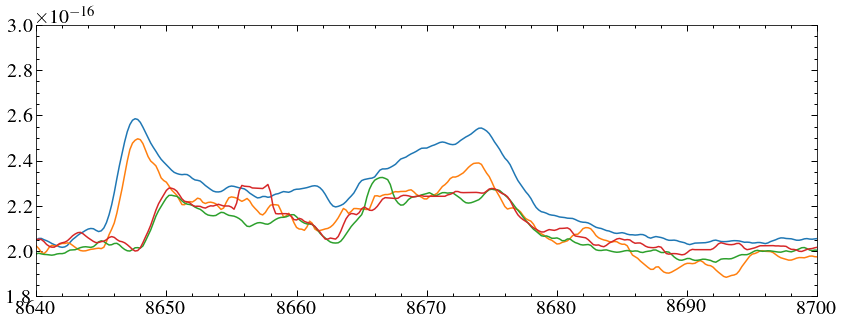

In [3]:
smooth =10
for ft in fitsfiles:
    hdul = fits.open(ft)
    hdr = hdul[0].header
    data = hdul[1].data[0]
    hdul.close()
    if hdr['DISPELEM'] == 'VIS':
        w, f, e, q = data['WAVE'], data['FLUX'], data['ERR'], data['QUAL']
        w, f, e = w[q==0], f[q==0], e[q==0]
        w *=10
        print(ft)
        print(hdr['DATE-OBS'])
        f = convolve(f,Box1DKernel(smooth))
        e = convolve(e,Box1DKernel(smooth))/(smooth**0.5)
        if hdr['DATE-OBS'] == '2018-12-29T04:40:24.538': #last spectrum has lower continuum, scaling it up a bit
            f *=1.1
        plt.plot(w[1000:],f[1000:])
        plt.xlim(8640, 8700)
        plt.ylim(0.18e-15, 0.3e-15)
   #     plt.show()

Somewhat weaker - need to normalise and measure EW, but might be interesting. Assume Chris is on top of it.

In [4]:
def make_plot_spec(w, f, e, mask1, mask2, smooth=10): #cuts spectrum down to the bit to plot
    #mask = (w > 8450) & (w < 8480) | (w > 8520) & (w <8540) | (w > 8560) & (w< 8660) | (w > 8680) & (w < 8700) #mask out emmission lines
    w1, f1 = w[mask1], f[mask1]
    n_init = models.Polynomial1D(3)
    n_fit = fitter(n_init, w1, f1)
    #mask = (w > 8450) & (w < 8700)
    nf = f/n_fit(w)
    ne = e/n_fit(w)
    if smooth == 0:
        smooth = 1
    nf = convolve(nf,Box1DKernel(smooth))
    ne = convolve(ne,Box1DKernel(smooth))/smooth**0.5
    w1, f1, e1 = w[mask2], nf[mask2], ne[mask2]
    return w1,f1, e1
    

2011-01-29T02:50:02.972
2014-10-20T08:29:36.829
2018-01-06T04:50:08.378
2018-12-29T04:40:24.538
[[-5.16974718 -4.02061274 -2.92087647 -2.39417372]
 [-5.89340787 -4.53180057 -2.99778626 -2.78230721]
 [-4.82970274 -4.00369207 -2.85478097 -2.27400558]]


 [astropy.modeling.fitting]
 [astropy.modeling.fitting]
 [astropy.modeling.fitting]
 [astropy.modeling.fitting]


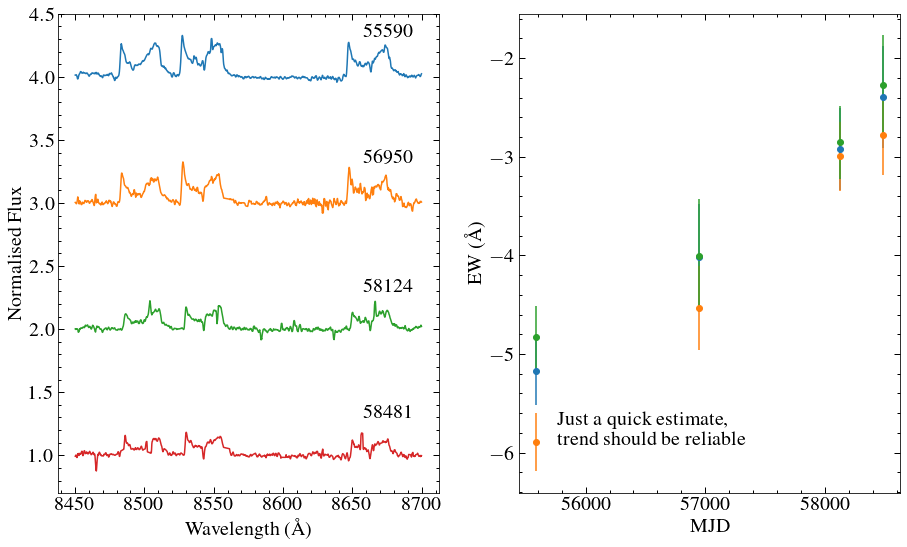

In [5]:
fitter = fitting.LinearLSQFitter()

def wavelength_edges(w, gap=10):
    """
    Calulates w0 and w1, accounting for gaps induced by masking etc
    """
    diff = np.diff(w)
   # diff = np.insert(diff, 0, diff[0]) #adds an extravalue to make len(diff) = len(w)
    diff = np.insert(diff, (0, len(diff)), (diff[0], diff[-1])) #adds an extravalue to make len(diff) = len(w)+1
    w0 = []
    w1 = []
    for i, wi in enumerate(w):
        w0i, w1i = diff[i]/2, diff[i+1]/2
        if (max(w0i, w1i)/min(w0i, w1i)) > gap:
            w0i, w1i = min(w0i, w1i), min(w0i, w1i)
        w0.append(wi - w0i)
        w1.append(wi + w1i)
   # w0 = w - diff/2.
   # w1 = w + diff/2.
    
    return np.array(w0), np.array(w1)

trips = [[8475,8520], [8520,8560], [8645, 8680]]
dates = []
eqs = []
n = 3
i = 0

eqs = np.ndarray(shape=(3,4), dtype=float)
eqse = np.ndarray(shape=(3,4), dtype=float)

plt.figure(figsize=(13, 8))
plt.subplot(121)
for ft in fitsfiles:
    hdul = fits.open(ft)
    hdr = hdul[0].header
    data = hdul[1].data[0]
    hdul.close()
    if hdr['DISPELEM'] == 'VIS':
        w, f, e, q = data['WAVE'], data['FLUX'], data['ERR'], data['QUAL']
        w, f, e = w[q==0], f[q==0], e[q==0]
        w *=10
        
        print(hdr['DATE-OBS'])
       # f = convolve(f,Box1DKernel(smooth))
       # e = convolve(e,Box1DKernel(smooth))/(smooth**0.5)
  
        mask1 = (w > 8400) & (w < 8475) | (w > 8515) & (w < 8522) | (w > 8565)  & (w< 8640) | (w > 8685) & (w < 8750)
        mask2 = (w> 8450) & (w < 8700) 
        w, f, e =  make_plot_spec(w, f,e , mask1, mask2, smooth=5)
        plt.plot(w, f+n)
       # plt.xlim(8460, 8690)
      #  plt.ylim(0.9, 1.3)
        date = hdr['MJD-OBS']# +  (fits.getheader(s[:-3]+'fits')['EXPTIME'])/(2*86400)
        dates.append(date)
        w0, w1 = wavelength_edges(w)
        
        for j , trip in enumerate(trips):
            mask = (w > trip[0]) & (w < trip[1])
            eqw = np.sum((1-f[mask])*(w1[mask]-w0[mask]))
            #eqw_e = (np.sum(e[mask]**2 * (w1[mask]-w0[mask])**2))**0.5
            eqw_e=((1.+(1./np.mean(f[mask])))**(0.5)) * (((w[mask][-1]-w[mask][0])-eqw)/(np.mean(f[mask])/np.mean(e[mask])))
            
            eqs[[j],[i]] = eqw
            eqse[[j],[i]] = eqw_e
            
      
        
    #    eqw = np.sum((1-f)*(w1-w0))
     #   eqw_e = (np.sum(e**2 * (w1-w0)**2))**0.5

       # eqw=(w[-1]-w[0])*(1.-np.mean(f))
        #print(eqw, eqw_e)
        #eqs.append(eqw)
        plt.annotate(int(np.floor(date)), (0.8, n+1.3), xycoords = ('axes fraction', 'data'))
        
        
        n -=1
        i +=1
print(eqs)
    
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Normalised Flux')
#plt.tight_layout()
#eqs = np.array(eqs)
plt.subplot(122)

for i in range(len(trips)):

    plt.errorbar(dates, eqs[i], yerr=eqse[i], marker='o', ls='none')
#plt.ylim(-5, -19)
plt.xlabel('MJD')
plt.ylabel('EW (\AA)')
plt.annotate('Just a quick estimate,\n trend should be reliable', (0.1,0.1), xycoords='axes fraction' )
plt.tight_layout()
#plt.savefig('plots/0845_xshoo_ql.pdf', dpi=150)
eqsx= eqs
datesx = dates
ex = eqse

Add the other data?

In [6]:
# path2 = '/media/david/5tb_storage1/gas_discs/0845/other_data/'
path2 = '/media/david/2tb_ext_hd/hddata/het_gas/other_data/'
specs = glob.glob(path2+'*.dat')
specs

['/media/david/2tb_ext_hd/hddata/het_gas/other_data/200412_SDSS_norm.dat',
 '/media/david/2tb_ext_hd/hddata/het_gas/other_data/200801_ISIS_norm.dat',
 '/media/david/2tb_ext_hd/hddata/het_gas/other_data/200804_UVES_norm.dat',
 '/media/david/2tb_ext_hd/hddata/het_gas/other_data/200901_UVES_norm.dat',
 '/media/david/2tb_ext_hd/hddata/het_gas/other_data/200904_UVES_norm.dat',
 '/media/david/2tb_ext_hd/hddata/het_gas/other_data/201004_GMOS-S_norm.dat',
 '/media/david/2tb_ext_hd/hddata/het_gas/other_data/202003_FORS2_norm.dat']

/media/david/2tb_ext_hd/hddata/het_gas/other_data/200412_SDSS_norm.dat


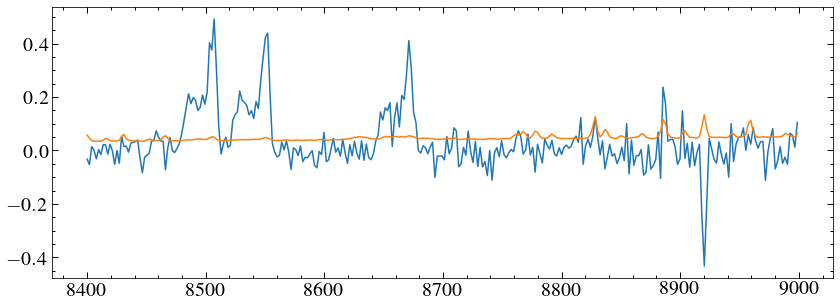

/media/david/2tb_ext_hd/hddata/het_gas/other_data/200801_ISIS_norm.dat


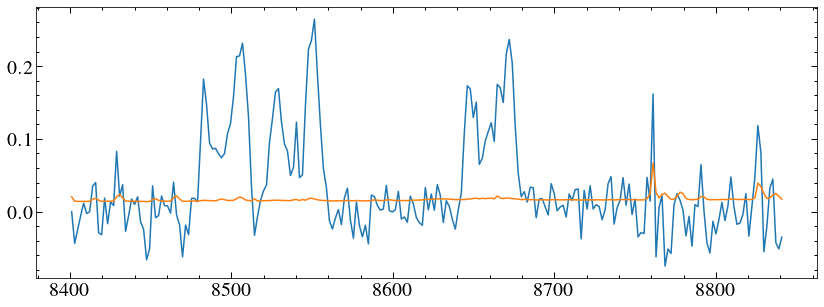

/media/david/2tb_ext_hd/hddata/het_gas/other_data/200804_UVES_norm.dat


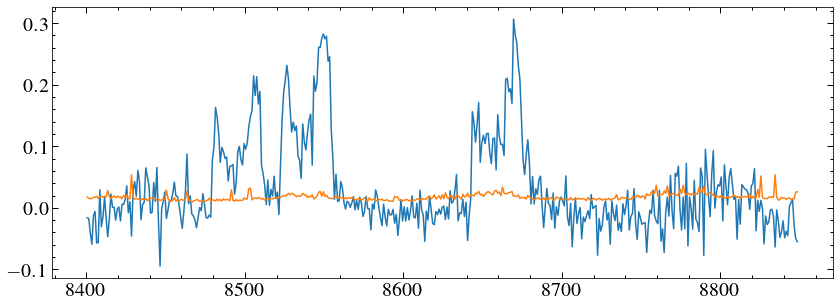

/media/david/2tb_ext_hd/hddata/het_gas/other_data/200901_UVES_norm.dat


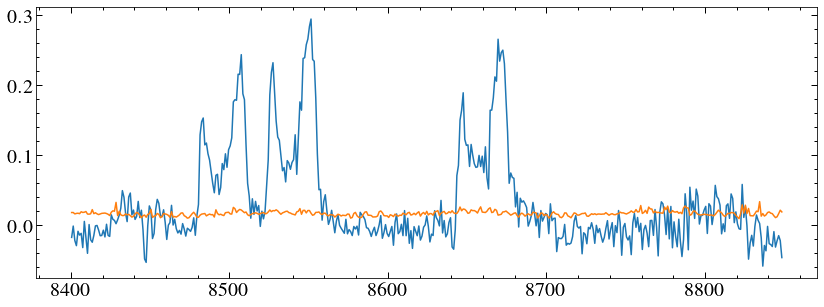

/media/david/2tb_ext_hd/hddata/het_gas/other_data/200904_UVES_norm.dat


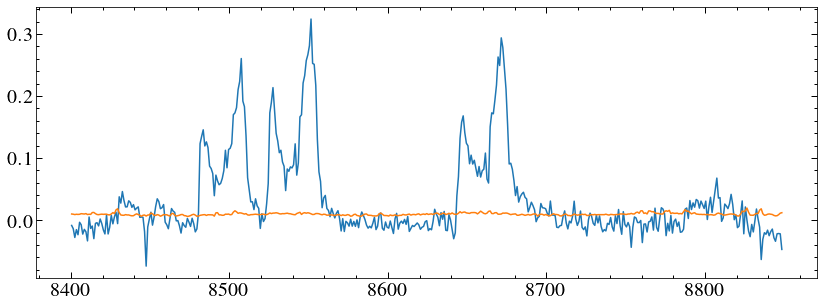

/media/david/2tb_ext_hd/hddata/het_gas/other_data/201004_GMOS-S_norm.dat


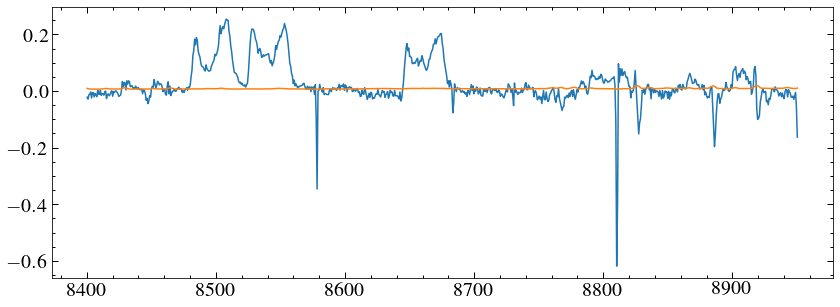

/media/david/2tb_ext_hd/hddata/het_gas/other_data/202003_FORS2_norm.dat


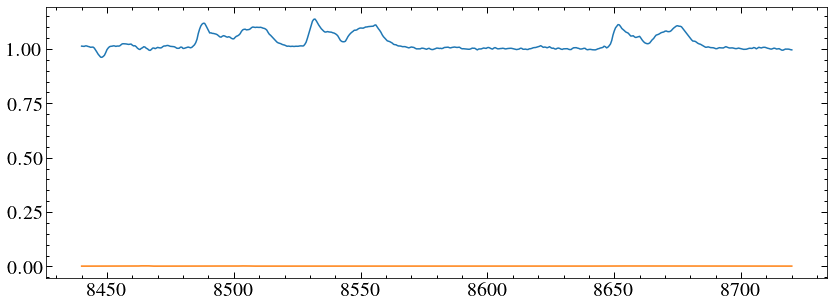

In [7]:
for i, spec in enumerate(specs):
    print(spec)
    w, f, e= np.loadtxt(spec, unpack=True)
    plt.plot(w,f)
    plt.plot(w,e)
    plt.show()

[53354. 54480. 54571. 54846. 54936. 55301. 58923.]
/media/david/2tb_ext_hd/hddata/het_gas/other_data/200412_SDSS_norm.dat
/media/david/2tb_ext_hd/hddata/het_gas/other_data/200801_ISIS_norm.dat
/media/david/2tb_ext_hd/hddata/het_gas/other_data/200804_UVES_norm.dat
/media/david/2tb_ext_hd/hddata/het_gas/other_data/200901_UVES_norm.dat
/media/david/2tb_ext_hd/hddata/het_gas/other_data/200904_UVES_norm.dat
/media/david/2tb_ext_hd/hddata/het_gas/other_data/201004_GMOS-S_norm.dat
/media/david/2tb_ext_hd/hddata/het_gas/other_data/202003_FORS2_norm.dat
Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
            slope             intercept     
    --------------------- ------------------
    0.0020515726366603657 -128.3645390182615
[1.64330842e-04 9.56684204e+00]
0.7493369055401986 Angstrom / yr
0.060021840008676025 Angstrom / yr


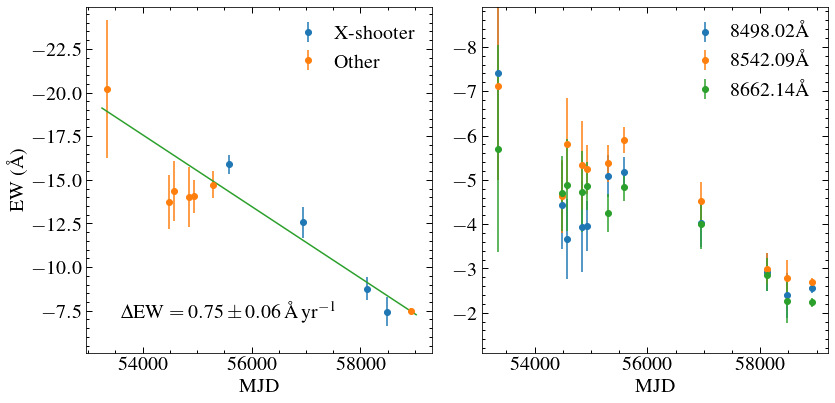

2011-01-29T02:50:02.972
2014-10-20T08:29:36.829
2018-01-06T04:50:08.378
2018-12-29T04:40:24.538


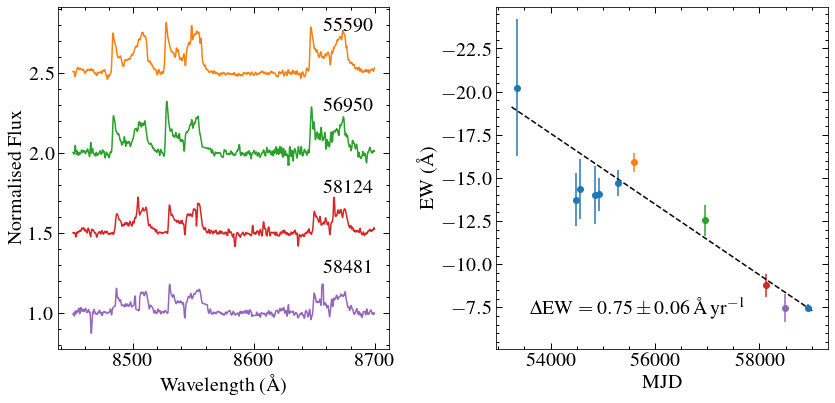

In [8]:
dates = []
for spec in specs:
    fname = os.path.split(spec)[1]
    date = fname[0:6]
    dates.append('{}-{}-15'.format(date[0:4], date[4:6]))
dates = Time(dates, format='iso')
# dates.mjd
dates = dates.mjd
print(dates)

eqs = np.ndarray(shape=(3,len(specs)), dtype=float)
eqse = np.ndarray(shape=(3,len(specs)), dtype=float)


for i, spec in enumerate(specs):
    print(spec)
    w, f, e= np.loadtxt(spec, unpack=True)
    if 'FORS2' not in spec:
        f +=1
    #plt.plot(w, f)
   # print(w[0],w[-1])
    #plt.show()

    #mask1 = (w > 8400) & (w < 8475) | (w > 8515) & (w < 8522) | (w > 8565)  & (w< 8640) | (w > 8685) & (w < 8720)
    #mask2 = (w> 8450) & (w < 8700) 
    #w, f, e =  make_plot_spec(w, f,e , mask1, mask2, smooth=2)
    #plt.plot(w, f)
    #plt.ylim(0,2)
    w0, w1 = wavelength_edges(w)
        
    for j , trip in enumerate(trips):
        mask = (w > trip[0]) & (w < trip[1])
        eqw = np.sum((1-f[mask])*(w1[mask]-w0[mask]))
        #eqw_e = (np.sum(e[mask]**2 * (w1[mask]-w0[mask])**2))**0.5
        eqw_e=((1.+(1./np.mean(f[mask])))**(0.5)) * (((w[mask][-1]-w[mask][0])-eqw)/(np.mean(f[mask])/np.mean(e[mask])))
        eqs[[j],[i]] = eqw
        eqse[[j],[i]] = eqw_e
            
lines = [8498.02,8542.09,8662.14]   
        
plt.figure(figsize=(12, 6))
plt.subplot(122)
for i in range(len(trips)):

    plt.errorbar(dates, eqs[i], yerr=eqse[i], marker='o', ls='none', c= 'C{}'.format(i), label = r'{}\AA'.format(lines[i]))
    plt.errorbar(datesx, eqsx[i], yerr=ex[i], marker='o', ls='none', c= 'C{}'.format(i))
plt.ylim(-1.1, -8.9)
plt.legend()
#plt.show()
plt.xlabel('MJD')

plt.subplot(121)
#plt.figure(figsize=(8, 6))   
ew_sum = np.sum(eqs, axis=0)
eewsum = np.sum(eqse**2, axis=0)**0.5
ew_sumx = np.sum(eqsx, axis=0)
eewsumx = np.sum(ex**2, axis=0)**0.5


plt.errorbar(datesx, np.sum(eqsx, axis=0), yerr= np.sum(ex**2, axis=0)**0.5, marker='o', ls='none', c= 'C0', label='X-shooter')
plt.errorbar(dates, np.sum(eqs, axis=0), yerr=np.sum(eqse**2, axis=0)**0.5, marker='o', ls='none', c= 'C1', label='Other')

adates = np.concatenate((dates, datesx))
aew = np.concatenate((ew_sum, ew_sumx))
aewe = np.concatenate((eewsum, eewsumx))

args = np.argsort(adates)
adates, aew, aewe = adates[args], aew[args], aewe[args]

fitter = fitting.LevMarLSQFitter()
p_init = models.Linear1D()
# p_fit = fitter(p_init, adates[6:], aew[6:], weights = 1/aewe[6:])
p_fit = fitter(p_init, adates, aew, weights = 1/aewe)
tplot = np.linspace(min(adates)-100, max(adates)+100, 100)
plt.plot(tplot, p_fit(tplot), c='C2')
print(p_fit)
#print(fitter.fit_info)
fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
print(fit_e)

slope = (p_fit.slope*u.AA/u.d).to(u.AA/u.yr)
print(slope)
print((fit_e[0]/p_fit.slope)*slope)

#S= ((fitter.fit_info['residuals'][0]/(len(adates)-2))**0.5)
#print(S)
plt.annotate(r'$\Delta \mathrm{EW} = 0.75\pm0.06$\,\AA\,yr$^{-1}$', (0.1, 0.1), xycoords='axes fraction')

plt.ylim(-5.1, -24.9)
plt.legend()
plt.xlabel('MJD')
plt.ylabel('EW (\AA)')
plt.tight_layout()
#plt.savefig('plots/0845_ews.pdf', dpi=150)

plt.show()

#plot with spectra
cols = np.array(['C1', 'C2', 'C3', 'C4'])
n = 1.5
i = 0
plt.figure(figsize=(12, 6))
plt.subplot(121)
for ft in fitsfiles:
    hdul = fits.open(ft)
    hdr = hdul[0].header
    data = hdul[1].data[0]
    hdul.close()
    if hdr['DISPELEM'] == 'VIS':
        w, f, e, q = data['WAVE'], data['FLUX'], data['ERR'], data['QUAL']
        w, f, e = w[q==0], f[q==0], e[q==0]
        w *=10
        
        print(hdr['DATE-OBS'])
       # f = convolve(f,Box1DKernel(smooth))
       # e = convolve(e,Box1DKernel(smooth))/(smooth**0.5)
  
        mask1 = (w > 8400) & (w < 8475) | (w > 8515) & (w < 8522) | (w > 8565)  & (w< 8640) | (w > 8685) & (w < 8750)
        mask2 = (w> 8450) & (w < 8700) 
        w, f, e =  make_plot_spec(w, f,e , mask1, mask2, smooth=5)
        plt.plot(w, f+n, c=cols[i])
        date = hdr['MJD-OBS']# +  (fits.getheader(s[:-3]+'fits')['EXPTIME'])/(2*86400)
      
        plt.annotate(int(np.floor(date)), (0.8, n+1.25), xycoords = ('axes fraction', 'data'))
        n-=0.5
        i +=1
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Normalised Flux') 
#plt.ylim(0.8)
plt.subplot(122)

for i in range(len(datesx)):
    plt.errorbar(datesx[i], np.sum(eqsx, axis=0)[i], yerr= (np.sum(ex**2, axis=0)**0.5)[i], marker='o', ls='none', c=cols[i], label='X-shooter')
plt.errorbar(dates, np.sum(eqs, axis=0), yerr=np.sum(eqse**2, axis=0)**0.5, marker='o', ls='none', c= 'C0', label='Other')
plt.plot(tplot, p_fit(tplot), c='k', ls='--')
plt.annotate(r'$\Delta \mathrm{EW} = 0.75\pm0.06$\,\AA\,yr$^{-1}$', (0.1, 0.1), xycoords='axes fraction')

plt.ylim(-5.1, -24.9)
#plt.legend()
plt.xlabel('MJD')
plt.ylabel('EW (\AA)')
plt.tight_layout()
plt.savefig('plots/0845_ew_spec.pdf', dpi=150)
plt.savefig('plots/0845_ew_spec.png', dpi=150)

Looks real. To do- proper errorbars, look at TESS, nice plot? No TESS coverage.

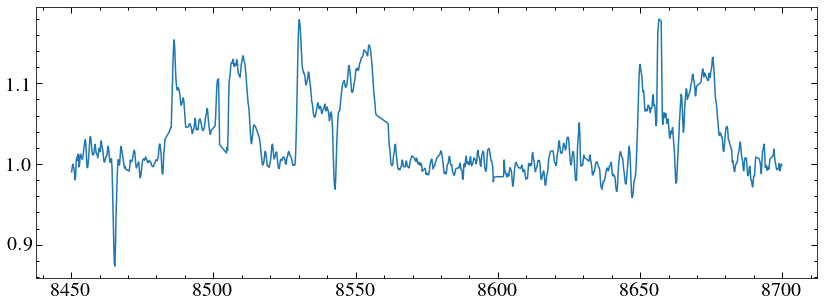

In [9]:
plt.plot(w, f)

20210108 got some LRS2 data

In [10]:
# hetpath = '/media/david/5tb_storage1/gas_discs/0845/het_data/UT21-1-016/'
hetpath = '/media/david/2tb_ext_hd/hddata/het_gas/UT21-1-016/'

In [11]:
hetspecs = glob.glob('{}spectrum*d.fits'.format(hetpath)) #just the red arm
hetspecs

['/media/david/2tb_ext_hd/hddata/het_gas/UT21-1-016/spectrum_20210108_0000023_exp01_farred.fits',
 '/media/david/2tb_ext_hd/hddata/het_gas/UT21-1-016/spectrum_20210108_0000023_exp01_red.fits']

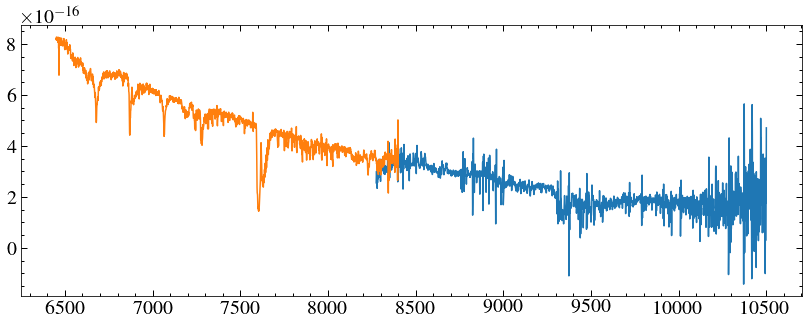

In [12]:
for spec in hetspecs:
    data = fits.getdata(spec)
    w, f, e = data[0], data[1], data[3]
    plt.plot(w,f)
#plt.xlim(8450, 8700)

In [13]:
frspec = hetspecs[0]
data = fits.getdata(frspec)
w, f, e = data[0], data[1], data[3]
# plt.step(w,f, where='mid')
# plt.plot(w,e)
# plt.xlim(8400, 8700)
# plt.ylim(2e-16, 5e-16)
# [plt.axvline(line, ls='--', c='C2') for line in lines]

In [14]:
# mask1 = (w > 8400) & (w < 8475) | (w > 8515) & (w < 8522) | (w > 8565)  & (w< 8640) | (w > 8685) & (w < 8750)
# mask2 = (w> 8450) & (w < 8700) 
# wn, fn, en =  make_plot_spec(w, f,e , mask1, mask2, smooth=2)
# plt.plot(wn, fn)
# plt.plot(wn, en)

# print(specs[-1])
# wfor, ffor, efor= np.loadtxt(specs[-1], unpack=True)
# plt.plot(wfor,ffor)
# plt.plot(wfor, efor)
# [plt.axvline(line, ls='--', c='C2') for line in lines]
# plt.show()
# plt.plot(wn, fn/en)

In [15]:
# fits.getheader(hetspecs[0])

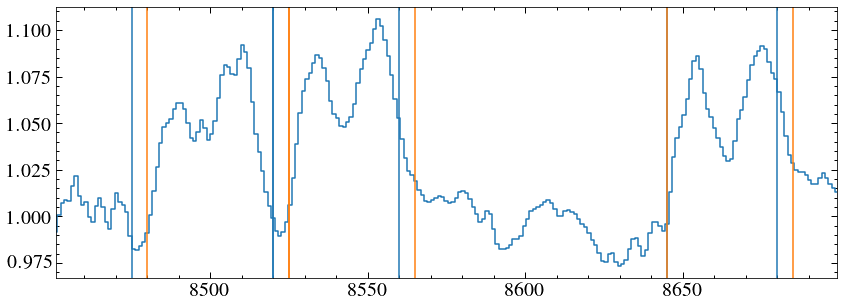

In [16]:
#wideing trips a bit,see if that makes error better
trips2 = [[8480,8525], [8525,8565], [8645, 8685]]

mask1 = (w > 8400) & (w < 8475) | (w > 8515) & (w < 8522) | (w > 8565)  & (w< 8640) | (w > 8685) & (w < 8750)
mask2 = (w> 8450) & (w < 8700) 
wn, fn, en =  make_plot_spec(w, f,e , mask1, mask2, smooth=10)
plt.step(wn, fn, where='mid')
plt.xlim(8451, 8699)

for trip in trips:
    [plt.axvline(line) for line in trip]
    
for trip in trips2:
    [plt.axvline(line, c='C1') for line in trip]    

EW?

In [17]:
wn, fn, en =  make_plot_spec(w, f,e , mask1, mask2, smooth=10)
w0, w1 = wavelength_edges(wn)
lrs2_ew = []
lrs2_ewe = []
for j , trip in enumerate(trips2):
        mask = (wn > trip[0]) & (wn < trip[1])
        eqw = np.sum((1-fn[mask])*(w1[mask]-w0[mask]))
        #eqw_e = (np.sum(e[mask]**2 * (w1[mask]-w0[mask])**2))**0.5
        eqw_e=((1.+(1./np.mean(fn[mask])))**(0.5)) * (((wn[mask][-1]-wn[mask][0])-eqw)/(np.mean(fn[mask])/np.mean(en[mask])))
        lrs2_ew.append(eqw)
        lrs2_ewe.append(eqw_e)
        #eqs[[j],[i]] = eqw
        #eqse[[j],[i]] = eqw_e
print(lrs2_ew)
print(lrs2_ewe)

lrs2_ew, lrs2_ewe = np.array(lrs2_ew), np.array(lrs2_ewe)

print(np.sum(lrs2_ew))
print(np.sum(lrs2_ewe**2)**0.5)



[-1.9717595018175242, -2.57994247272406, -2.324310935976006]
[0.6012303249493813, 0.5181250051714509, 0.6158550183323399]
-6.87601291051759
1.0045938623283448


In [18]:

lrs2_mjd = 59222.4584767111

p_fit(lrs2_mjd)


-6.865363731686273

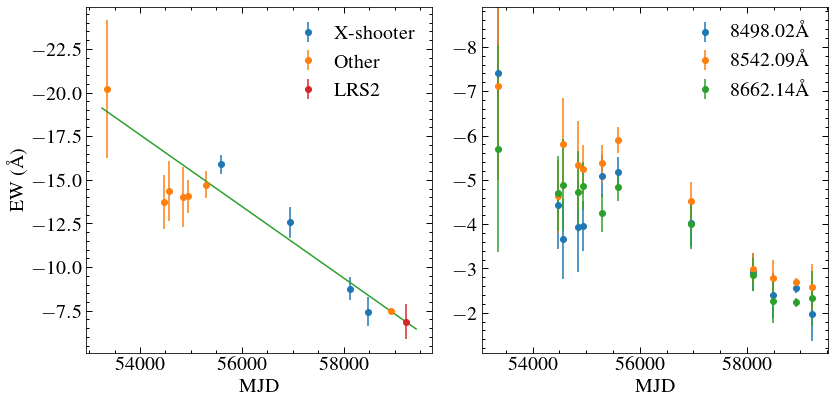

In [19]:
plt.figure(figsize=(12, 6))
plt.subplot(122)
for i in range(len(trips)):

    plt.errorbar(dates, eqs[i], yerr=eqse[i], marker='o', ls='none', c= 'C{}'.format(i), label = r'{}\AA'.format(lines[i]))
    plt.errorbar(datesx, eqsx[i], yerr=ex[i], marker='o', ls='none', c= 'C{}'.format(i))
    
#add lrs2  
for i in range(len(lrs2_ew)):
    plt.errorbar(lrs2_mjd, lrs2_ew[i], yerr=lrs2_ewe[i], marker='o', ls='none', c= 'C{}'.format(i))

plt.ylim(-1.1, -8.9)
plt.legend()

plt.xlabel('MJD')

plt.subplot(121)


plt.errorbar(datesx, np.sum(eqsx, axis=0), yerr= np.sum(ex**2, axis=0)**0.5, marker='o', ls='none', c= 'C0', label='X-shooter')
plt.errorbar(dates, np.sum(eqs, axis=0), yerr=np.sum(eqse**2, axis=0)**0.5, marker='o', ls='none', c= 'C1', label='Other')
#add lrsw
plt.errorbar(lrs2_mjd, np.sum(lrs2_ew), yerr=np.sum(lrs2_ewe**2)**0.5, marker='o', ls='none', c= 'C3', label='LRS2')

tplot = np.linspace(min(adates)-100, max(adates)+500, 100)
plt.plot(tplot, p_fit(tplot), c='C2')

plt.ylim(-5.1, -24.9)
plt.legend()
plt.xlabel('MJD')
plt.ylabel('EW (\AA)')
plt.tight_layout()
#plt.savefig('plots/0845_ews.pdf', dpi=150)



plt.show()


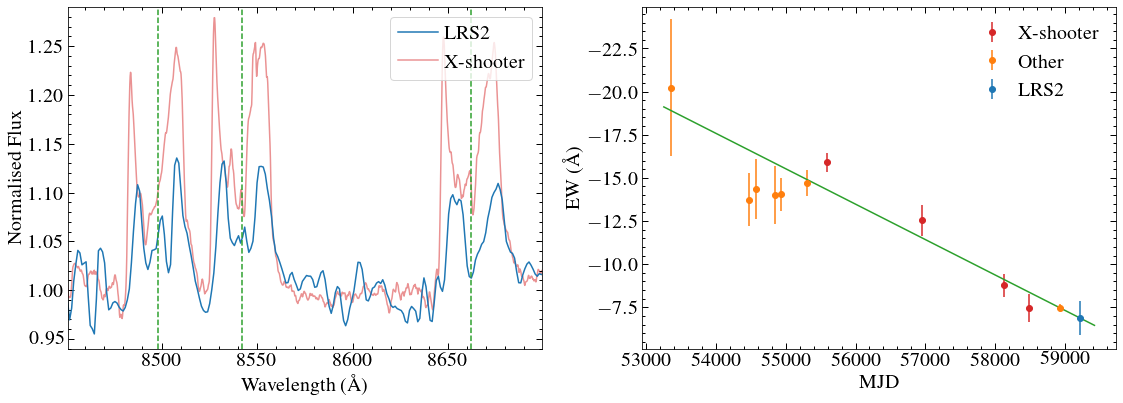

In [20]:

plt.figure(figsize=(16, 6))

plt.subplot(122)


plt.errorbar(datesx, np.sum(eqsx, axis=0), yerr= np.sum(ex**2, axis=0)**0.5, marker='o', ls='none', c= 'C3', label='X-shooter')
plt.errorbar(dates, np.sum(eqs, axis=0), yerr=np.sum(eqse**2, axis=0)**0.5, marker='o', ls='none', c= 'C1', label='Other')
#add lrsw
plt.errorbar(lrs2_mjd, np.sum(lrs2_ew), yerr=np.sum(lrs2_ewe**2)**0.5, marker='o', ls='none', c= 'C0', label='LRS2')

tplot = np.linspace(min(adates)-100, max(adates)+500, 100)
plt.plot(tplot, p_fit(tplot), c='C2')

plt.ylim(-5.1, -24.9)
plt.legend()
plt.xlabel('MJD')
plt.ylabel('EW (\AA)')

plt.subplot(121)

frspec = hetspecs[0]
data = fits.getdata(frspec)
w, f, e = data[0], data[1], data[3]
mask1 = (w > 8400) & (w < 8475) | (w > 8515) & (w < 8522) | (w > 8565)  & (w< 8640) | (w > 8685) & (w < 8750)
mask2 = (w> 8450) & (w < 8700) 
wn, fn, en =  make_plot_spec(w, f,e , mask1, mask2, smooth=4)
plt.plot(wn, fn,label='LRS2')

ft = '/media/david/2tb_ext_hd/hddata/het_gas/xshooter/ADP.2014-05-16T12ː14ː36.307'
data = fits.getdata(ft)
w, f, e, q = data['WAVE'], data['FLUX'], data['ERR'], data['QUAL']
w, f, e = w[q==0], f[q==0], e[q==0]
w *=10
mask1 = (w > 8400) & (w < 8475) | (w > 8515) & (w < 8522) | (w > 8565)  & (w< 8640) | (w > 8685) & (w < 8750)
mask2 = (w> 8450) & (w < 8700) 
wn, fn, en =  make_plot_spec(w, f,e , mask1, mask2, smooth=10)
plt.plot(wn, fn,label='X-shooter', c='C3', zorder=-2, alpha =0.5)


plt.legend(frameon=True)
plt.xlim(8451, 8699)
plt.ylim(0.94, 1.29)
[plt.axvline(line, ls='--', c='C2') for line in lines]
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Normalised Flux')

plt.tight_layout()
plt.savefig('plots/0845_lrs2_results.pdf', dpi=150)




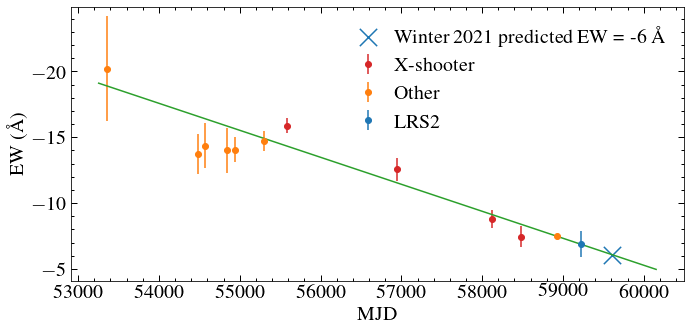

In [21]:
obsdates = [59563, 59594, 59625, 59653]


plt.figure(figsize=(10, 5))
plt.errorbar(datesx, np.sum(eqsx, axis=0), yerr= np.sum(ex**2, axis=0)**0.5, marker='o', ls='none', c= 'C3', label='X-shooter')
plt.errorbar(dates, np.sum(eqs, axis=0), yerr=np.sum(eqse**2, axis=0)**0.5, marker='o', ls='none', c= 'C1', label='Other')
#add lrsw
plt.errorbar(lrs2_mjd, np.sum(lrs2_ew), yerr=np.sum(lrs2_ewe**2)**0.5, marker='o', ls='none', c= 'C0', label='LRS2')

tplot = np.linspace(min(adates)-100, max(obsdates)+500, 100)
plt.plot(tplot, p_fit(tplot), c='C2')

prediction = p_fit(np.mean(obsdates))
plt.scatter(np.mean(obsdates), prediction, marker='x', label = 'Winter 2021 predicted EW = {0:.0f} \AA'.format(prediction), s=300)
# [plt.axvline(obs, ls='--', alpha=0.5, c='C2') for obs in obsdates]
# print(p_fit(obsdates))
plt.ylim(-4.1, -24.9)
plt.legend()
plt.xlabel('MJD')
plt.ylabel('EW (\AA)')
plt.tight_layout()
plt.savefig('plots/0845_prediction.pdf')

20211216 add the 1617 data?

In [22]:
from astropy.time import Time

<ErrorbarContainer object of 3 artists>

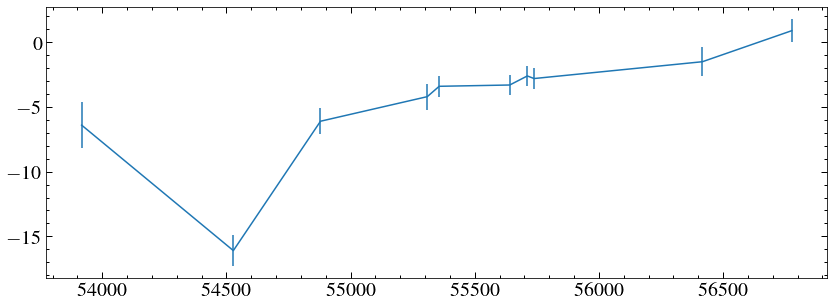

In [23]:
t1617 = Time(['2006-07-01', '2008-03-03', '2009-02-17', '2010-04-23','2010-06-10', '2011-03-21','2011-05-31', '2011-06-27', '2013-05-05', '2014-04-30'], scale='utc')
t1617 = t1617.mjd

ew1617 = [-6.4, -16.1, -6.1, -4.2, -3.4, -3.3, -2.6, -2.8, -1.5, 0.9]
ew_e1617 = [1.8, 1.2, 1.0,1.0, 0.8, 0.8,0.8,0.8, 1.1, 0.9]

plt.errorbar(t1617, ew1617,yerr= ew_e1617)

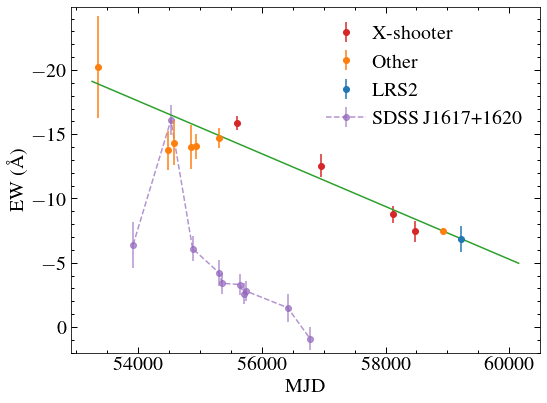

In [24]:
obsdates = [59563, 59594, 59625, 59653]


plt.figure(figsize=(8, 6))
plt.errorbar(datesx, np.sum(eqsx, axis=0), yerr= np.sum(ex**2, axis=0)**0.5, marker='o', ls='none', c= 'C3', label='X-shooter')
plt.errorbar(dates, np.sum(eqs, axis=0), yerr=np.sum(eqse**2, axis=0)**0.5, marker='o', ls='none', c= 'C1', label='Other')
#add lrsw
plt.errorbar(lrs2_mjd, np.sum(lrs2_ew), yerr=np.sum(lrs2_ewe**2)**0.5, marker='o', ls='none', c= 'C0', label='LRS2')

tplot = np.linspace(min(adates)-100, max(obsdates)+500, 100)
plt.plot(tplot, p_fit(tplot), c='C2')

# prediction = p_fit(np.mean(obsdates))
# plt.scatter(np.mean(obsdates), prediction, marker='x', label = 'Winter 2021 predicted EW = {0:.0f} \AA'.format(prediction), s=300)
# [plt.axvline(obs, ls='--', alpha=0.5, c='C2') for obs in obsdates]
# print(p_fit(obsdates))

plt.errorbar(t1617, ew1617,yerr= ew_e1617, marker='o', ls='--', c='C4', label = 'SDSS\,J1617+1620', alpha =0.7, zorder=-10)

plt.ylim(2, -24.9)
plt.legend()
plt.xlabel('MJD')
plt.ylabel('EW (\AA)')
plt.tight_layout()
plt.savefig('plots/1617_compare.pdf')

New data 20211229

/media/david/2tb_ext_hd/hddata/het_gas/UT22-1-013/spectrum_20211229_0000008_exp01_farred.fits
/media/david/2tb_ext_hd/hddata/het_gas/UT22-1-013/spectrum_20211229_0000008_exp01_red.fits
/media/david/2tb_ext_hd/hddata/het_gas/UT22-1-013/spectrum_20211229_0000008_exp02_farred.fits
/media/david/2tb_ext_hd/hddata/het_gas/UT22-1-013/spectrum_20211229_0000008_exp02_red.fits


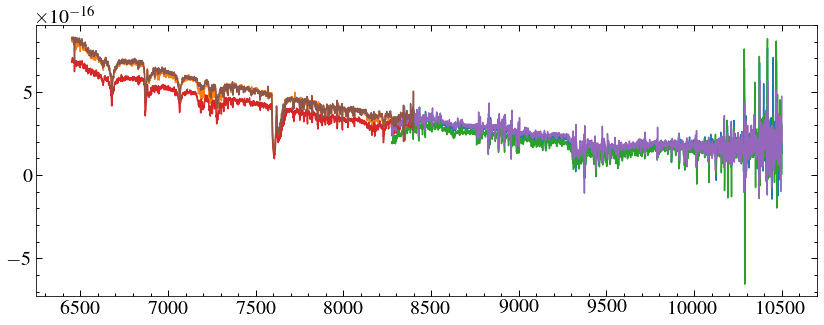

In [25]:
hetpath2 = '/media/david/2tb_ext_hd/hddata/het_gas/UT22-1-013/'
hetspecs2 = glob.glob('{}spectrum*20211229*d.fits'.format(hetpath2)) #just the red arm
# hetspecs
for spec in hetspecs2:
    print(spec)
    data = fits.getdata(spec)
    # star = fits.getheader(spec)['OBJECT']
    # print(star)
    w, f, e = data[0], data[1], data[3]
    plt.plot(w,f)
    

for spec in hetspecs:
    data = fits.getdata(spec)
    w, f, e = data[0], data[1], data[3]
    plt.plot(w,f)
#plt.xlim(8450, 8700)

In [26]:
def spectra_adder(f_array, e_array, rcs = True):
    """
    Returns a variance-weighted coadd with standard error of the weighted mean (variance weights, scale corrected).
    f_array and e_arrays are collections of flux and error arrays, which should have the same lenth and wavelength scale
    """
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    if rcs:
        rcs = np.sum((((flux - f_array)**2) * weights), axis=0) / (len(f_array)-1) #reduced chi-squared
        error = (var * rcs)**0.5
    else:
        error = var**0.5
    return flux, error

/media/david/2tb_ext_hd/hddata/het_gas/UT22-1-013/spectrum_20211229_0000008_exp01_farred.fits
/media/david/2tb_ext_hd/hddata/het_gas/UT22-1-013/spectrum_20211229_0000008_exp02_farred.fits


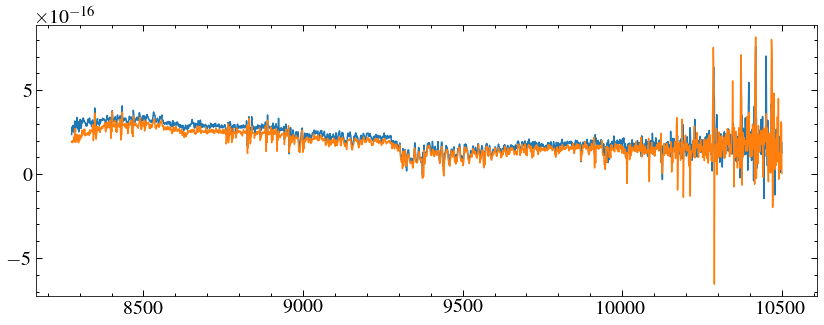

(8450.0, 8700.0)

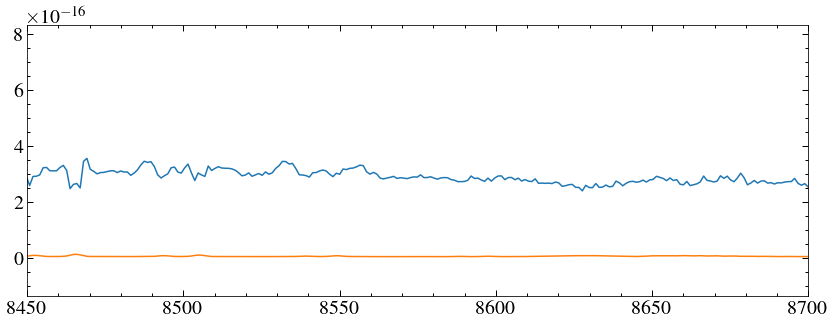

In [27]:
hetpath2 = '/media/david/2tb_ext_hd/hddata/het_gas/UT22-1-013/'
hetspecs2 = glob.glob('{}spectrum*20211229*farred.fits'.format(hetpath2)) #just the red arm
# hetspecs
fs = []
es = []
for spec in hetspecs2:
    print(spec)
    data = fits.getdata(spec)
    # star = fits.getheader(spec)['OBJECT']
    # print(star)
    w, f, e = data[0], data[1], data[3]
    # print(w[0], w[-1], len(w))
    plt.plot(w,f)
    fs.append(f)
    es.append(e)
plt.show()
    
w_dec = w
f_dec, e_dec = spectra_adder(np.array(fs), np.array(es), rcs=False)   
plt.plot(w_dec, f_dec)
plt.plot(w_dec, e_dec)

plt.xlim(8450, 8700)

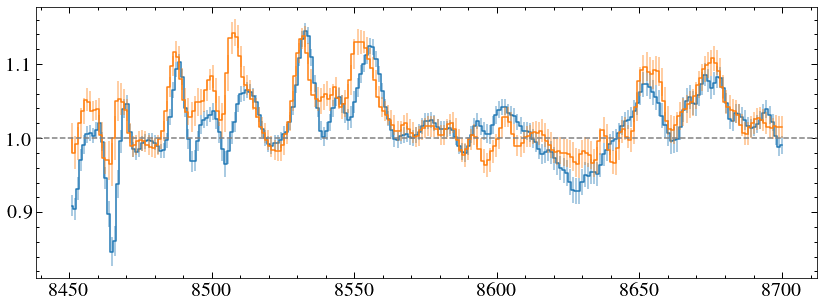

In [28]:
# frspec2 = hetspecs2[0]
# data = fits.getdata(frspec2)
# w, f, e = data[0], data[1], data[4]
# print(w[0])
w, f, e = w_dec, f_dec, e_dec
# mask1 = (w > 8435) & (w < 8440) |(w > 8470) & (w < 8480) | (w > 8520) & (w < 8522) | (w > 8565)  & (w< 8638) | (w > 8685) & (w < 8750)
mask1 = (w > 8470) & (w < 8475) | (w > 8515) & (w < 8522) | (w > 8565)  & (w< 8640) | (w > 8685) & (w < 8750)

mask2 = (w> 8450) & (w < 8700) 
wn, fn, en =  make_plot_spec(w, f,e , mask1, mask2, smooth=4)
wnd, fnd, end = wn, fn, en
plt.step(wn, fn, where='mid')
plt.errorbar(wn, fn, yerr=en, ls='none', alpha=0.5, c='C0')

frspec = hetspecs[0]
data = fits.getdata(frspec)
w, f, e = data[0], data[1], data[3]
mask1 = (w > 8470) & (w < 8475) | (w > 8515) & (w < 8522) | (w > 8565)  & (w< 8640) | (w > 8685) & (w < 8750)
mask2 = (w> 8450) & (w < 8700) 
wn, fn, en =  make_plot_spec(w, f,e , mask1, mask2, smooth=4)
plt.step(wn, fn,label='LRS2')
plt.errorbar(wn, fn, yerr=en, ls='none', alpha=0.5, c='C1')

plt.axhline(1, c='0.5', ls='--')

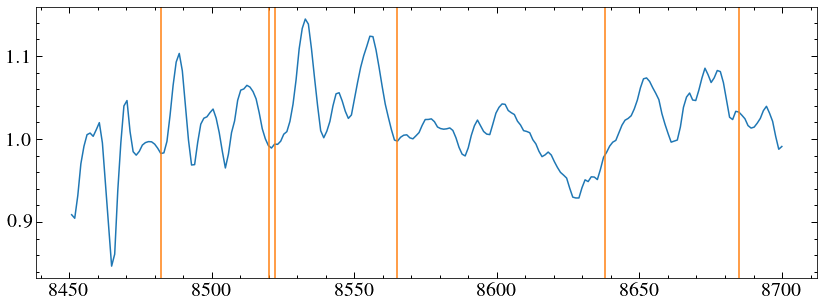

In [29]:
# frspec2 = hetspecs2[0]
# data = fits.getdata(frspec2)
w, f, e = w_dec, f_dec, e_dec
mask1 = (w > 8470) & (w < 8475) | (w > 8515) & (w < 8522) | (w > 8565)  & (w< 8640) | (w > 8685) & (w < 8750)

mask2 = (w> 8450) & (w < 8700) 
wn, fn, en =  make_plot_spec(w, f,e , mask1, mask2, smooth=4)
plt.plot(wn, fn)
# plt.plot(w,f)
# plt.xlim(8400, 8700)
# plt.ylim(1.7e-15, 2.5e-15)
plt.axvline(8482, c='C1')
plt.axvline(8520, c='C1')
plt.axvline(8522, c='C1')
plt.axvline(8565, c='C1')
plt.axvline(8638, c='C1')
plt.axvline(8685, c='C1')


# frspec = hetspecs[0]
# data = fits.getdata(frspec)
# w, f, e = data[0], data[1], data[3]
# mask1 = (w > 8400) & (w < 8475) | (w > 8515) & (w < 8522) | (w > 8565)  & (w< 8640) | (w > 8685) & (w < 8750)
# mask2 = (w> 8450) & (w < 8700) 
# wn, fn, en =  make_plot_spec(w, f,e , mask1, mask2, smooth=4)
# plt.plot(wn, fn,label='LRS2')
# plt.plot(w,f)

In [30]:
# wn, fn, en =  make_plot_spec(w, f,e , mask1, mask2, smooth=10)
w0, w1 = wavelength_edges(wn)
lrs2_ew2 = []
lrs2_ewe2 = []
for j , trip in enumerate(trips2):
        mask = (wn > trip[0]) & (wn < trip[1])
        eqw = np.sum((1-fn[mask])*(w1[mask]-w0[mask]))
        #eqw_e = (np.sum(e[mask]**2 * (w1[mask]-w0[mask])**2))**0.5
        eqw_e=((1.+(1./np.mean(fn[mask])))**(0.5)) * (((wn[mask][-1]-wn[mask][0])-eqw)/(np.mean(fn[mask])/np.mean(en[mask])))
        lrs2_ew2.append(eqw)
        lrs2_ewe2.append(eqw_e)
        #eqs[[j],[i]] = eqw
        #eqse[[j],[i]] = eqw_e
print(lrs2_ew2)
print(lrs2_ewe2)

lrs2_ew2, lrs2_ewe2 = np.array(lrs2_ew2), np.array(lrs2_ewe2)

print(np.sum(lrs2_ew2))
print(np.sum(lrs2_ewe2**2)**0.5)

lrs2_mjd2 = 59577


[-0.9041570544694819, -2.395483090254221, -1.842830174933112]
[0.7110672403877036, 0.6243312040384261, 0.8561571242103266]
-5.142470319656815
1.2760921181579141


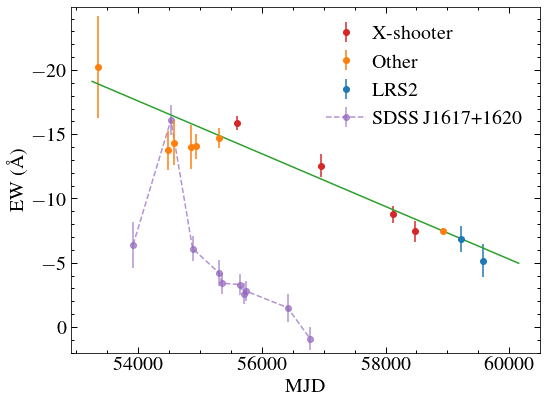

In [31]:
obsdates = [59563, 59594, 59625, 59653]


plt.figure(figsize=(8, 6))
plt.errorbar(datesx, np.sum(eqsx, axis=0), yerr= np.sum(ex**2, axis=0)**0.5, marker='o', ls='none', c= 'C3', label='X-shooter')
plt.errorbar(dates, np.sum(eqs, axis=0), yerr=np.sum(eqse**2, axis=0)**0.5, marker='o', ls='none', c= 'C1', label='Other')
#add lrsw
plt.errorbar(lrs2_mjd, np.sum(lrs2_ew), yerr=np.sum(lrs2_ewe**2)**0.5, marker='o', ls='none', c= 'C0', label='LRS2')
plt.errorbar(lrs2_mjd2, np.sum(lrs2_ew2), yerr=np.sum(lrs2_ewe2**2)**0.5, marker='o', ls='none', c= 'C0')


tplot = np.linspace(min(adates)-100, max(obsdates)+500, 100)
plt.plot(tplot, p_fit(tplot), c='C2')

# prediction = p_fit(np.mean(obsdates))
# plt.scatter(np.mean(obsdates), prediction, marker='x', label = 'Winter 2021 predicted EW = {0:.0f} \AA'.format(prediction), s=300)
# [plt.axvline(obs, ls='--', alpha=0.5, c='C2') for obs in obsdates]
# print(p_fit(obsdates))

plt.errorbar(t1617, ew1617,yerr= ew_e1617, marker='o', ls='--', c='C4', label = 'SDSS\,J1617+1620', alpha =0.7, zorder=-10)

plt.ylim(2, -24.9)
plt.legend()
plt.xlabel('MJD')
plt.ylabel('EW (\AA)')
plt.tight_layout()
plt.savefig('plots/sdssJ0845+2257_ews_202112.pdf')

/media/david/2tb_ext_hd/hddata/het_gas/UT22-1-013/spectrum_20220123_0000015_exp01_farred.fits
/media/david/2tb_ext_hd/hddata/het_gas/UT22-1-013/spectrum_20220123_0000015_exp02_farred.fits


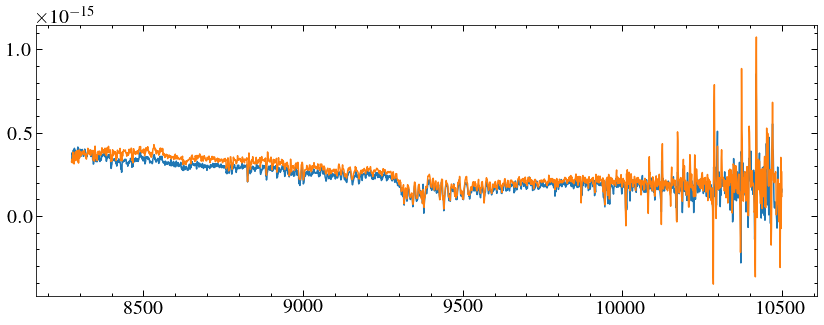

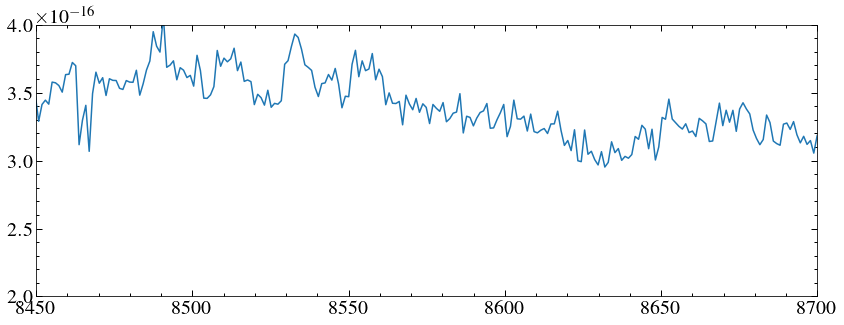

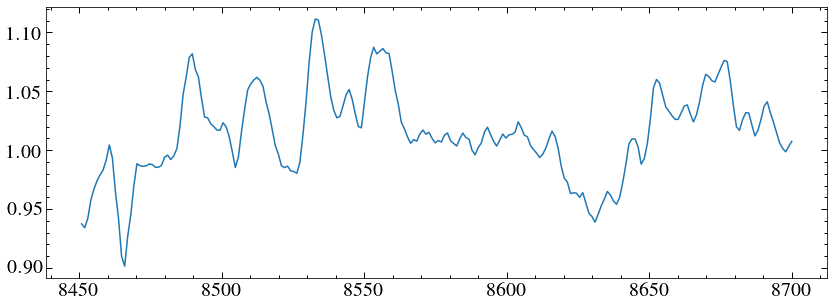

In [32]:
#and another one 
hetspecs3 = glob.glob('{}spectrum*20220123*farred.fits'.format(hetpath2)) #just the red arm
fs = []
es = []
for spec in hetspecs3:
    print(spec)
    data = fits.getdata(spec)
    # star = fits.getheader(spec)['OBJECT']
    # print(star)
    w, f, e = data[0], data[1], data[3]
    # print(w[0], w[-1], len(w))
    plt.plot(w,f)
    fs.append(f)
    es.append(e)
plt.show()
    
w_jan = w
f_jan, e_jan = spectra_adder(np.array(fs), np.array(es), rcs=False)   
plt.plot(w_jan, f_jan)
plt.plot(w_jan, e_jan)

plt.xlim(8450, 8700)
plt.ylim(2e-16, 4e-16)
plt.show()

w, f, e = w_jan, f_jan, e_jan
mask1 = (w > 8470) & (w < 8475) | (w > 8515) & (w < 8522) | (w > 8565)  & (w< 8640) | (w > 8685) & (w < 8750)

mask2 = (w> 8450) & (w < 8700) 
wn, fn, en =  make_plot_spec(w, f,e , mask1, mask2, smooth=4)
plt.plot(wn, fn)

In [33]:
w0, w1 = wavelength_edges(wn)
lrs2_ew3 = []
lrs2_ewe3 = []
for j , trip in enumerate(trips2):
        mask = (wn > trip[0]) & (wn < trip[1])
        eqw = np.sum((1-fn[mask])*(w1[mask]-w0[mask]))
        #eqw_e = (np.sum(e[mask]**2 * (w1[mask]-w0[mask])**2))**0.5
        eqw_e=((1.+(1./np.mean(fn[mask])))**(0.5)) * (((wn[mask][-1]-wn[mask][0])-eqw)/(np.mean(fn[mask])/np.mean(en[mask])))
        lrs2_ew3.append(eqw)
        lrs2_ewe3.append(eqw_e)
        #eqs[[j],[i]] = eqw
        #eqse[[j],[i]] = eqw_e
print(lrs2_ew3)
print(lrs2_ewe3)

lrs2_ew3, lrs2_ewe3 = np.array(lrs2_ew3), np.array(lrs2_ewe3)

print(np.sum(lrs2_ew3))
print(np.sum(lrs2_ewe3**2)**0.5)

lrs2_mjd3 = 59602

[-1.1207607195905798, -2.067422891901709, -1.5386192565331236]
[0.6995102359473134, 0.6181041461759083, 0.8199181076849492]
-4.726802868025413
1.2424302833658647


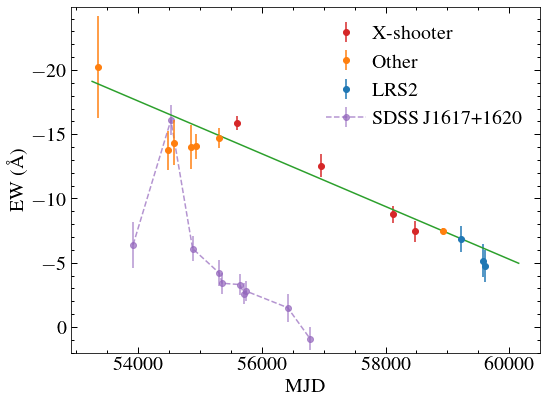

In [34]:
obsdates = [59563, 59594, 59625, 59653]


plt.figure(figsize=(8, 6))
plt.errorbar(datesx, np.sum(eqsx, axis=0), yerr= np.sum(ex**2, axis=0)**0.5, marker='o', ls='none', c= 'C3', label='X-shooter')
plt.errorbar(dates, np.sum(eqs, axis=0), yerr=np.sum(eqse**2, axis=0)**0.5, marker='o', ls='none', c= 'C1', label='Other')
#add lrs2
plt.errorbar(lrs2_mjd, np.sum(lrs2_ew), yerr=np.sum(lrs2_ewe**2)**0.5, marker='o', ls='none', c= 'C0', label='LRS2')
plt.errorbar(lrs2_mjd2, np.sum(lrs2_ew2), yerr=np.sum(lrs2_ewe2**2)**0.5, marker='o', ls='none', c= 'C0')
plt.errorbar(lrs2_mjd3, np.sum(lrs2_ew3), yerr=np.sum(lrs2_ewe3**2)**0.5, marker='o', ls='none', c= 'C0')

# plt.errorbar(dates, np.sum(eqs, axis=0), yerr=np.sum(eqse**2, axis=0)**0.5, marker='o', ls='none', c= 'C1', label='Other')


tplot = np.linspace(min(adates)-100, max(obsdates)+500, 100)
plt.plot(tplot, p_fit(tplot), c='C2')

# prediction = p_fit(np.mean(obsdates))
# plt.scatter(np.mean(obsdates), prediction, marker='x', label = 'Winter 2021 predicted EW = {0:.0f} \AA'.format(prediction), s=300)
# [plt.axvline(obs, ls='--', alpha=0.5, c='C2') for obs in obsdates]
# print(p_fit(obsdates))

plt.errorbar(t1617, ew1617,yerr= ew_e1617, marker='o', ls='--', c='C4', label = 'SDSS\,J1617+1620', alpha =0.7, zorder=-10)

plt.ylim(2, -24.9)
plt.legend()
plt.xlabel('MJD')
plt.ylabel('EW (\AA)')
plt.tight_layout()
plt.savefig('plots/sdssJ0845+2257_ews_202201.pdf')

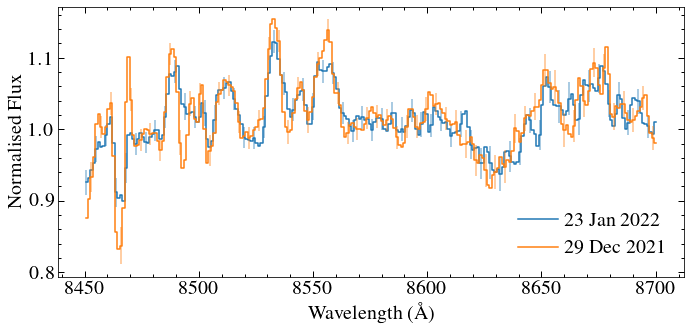

In [35]:
plt.figure(figsize=(10,5))
wn, fn, en =  make_plot_spec(w_jan, f_jan,e_jan , mask1, mask2, smooth=2)

plt.step(wn, fn, where='mid', label = '23 Jan 2022')
plt.errorbar(wn, fn, yerr=en, ls='none', alpha=0.5, c='C0', errorevery =4)
wnd, fnd, end =  make_plot_spec(w_dec, f_dec,e_dec , mask1, mask2, smooth=2)

plt.step(wnd, fnd, where='mid', label = '29 Dec 2021')
plt.errorbar(wnd, fnd, yerr=en, ls='none', alpha=0.5, c='C1',errorevery =(2,4))
plt.legend()
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Normalised Flux')
plt.tight_layout()
plt.savefig('plots/sdssj0845_dec_v_jan.pdf')

/media/david/2tb_ext_hd/hddata/het_gas/UT22-1-013/spectrum_20220123_0000015_exp01_farred.fits
/media/david/2tb_ext_hd/hddata/het_gas/UT22-1-013/spectrum_20220123_0000015_exp02_farred.fits


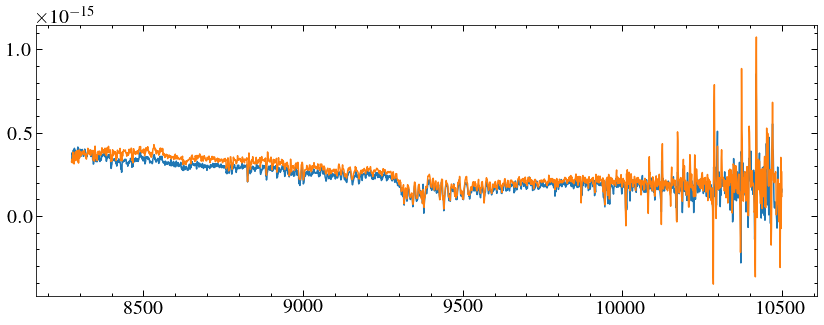

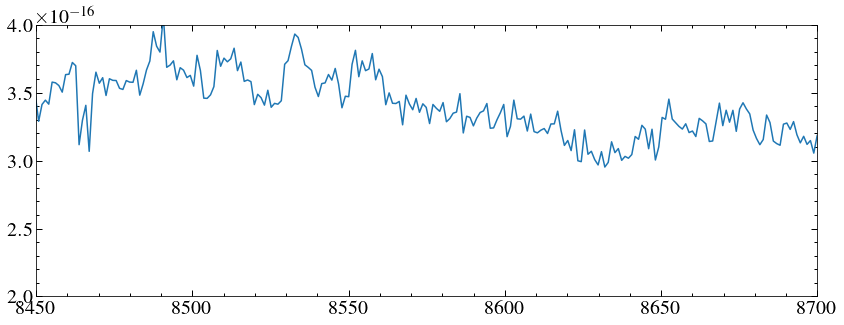

[-1.1207607195905798, -2.067422891901709, -1.5386192565331236]
[0.6995102359473134, 0.6181041461759083, 0.8199181076849492]
-4.726802868025413
1.2424302833658647


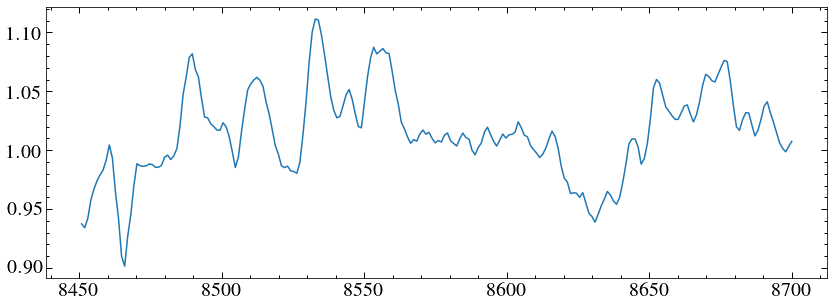

In [36]:
#and another one 
hetspecs4 = glob.glob('{}spectrum*20220210*farred.fits'.format(hetpath2)) #just the red arm
fs = []
es = []
for spec in hetspecs3:
    if fits.getheader(spec)['OBJECT'] == 'WDJ0845+2257_066_W':
        print(spec)
        data = fits.getdata(spec)
        # star = fits.getheader(spec)['OBJECT']
        # print(star)
        w, f, e = data[0], data[1], data[3]
        # print(w[0], w[-1], len(w))
        plt.plot(w,f)
        fs.append(f)
        es.append(e)
plt.show()
    
w_feb = w
f_feb, e_feb = spectra_adder(np.array(fs), np.array(es), rcs=False)   
plt.plot(w_feb, f_feb)
plt.plot(w_feb, e_feb)

plt.xlim(8450, 8700)
plt.ylim(2e-16, 4e-16)
plt.show()

w, f, e = w_feb, f_feb, e_feb
mask1 = (w > 8470) & (w < 8475) | (w > 8515) & (w < 8522) | (w > 8565)  & (w< 8640) | (w > 8685) & (w < 8750)

mask2 = (w> 8450) & (w < 8700) 
wn, fn, en =  make_plot_spec(w, f,e , mask1, mask2, smooth=4)
plt.plot(wn, fn)

w0, w1 = wavelength_edges(wn)
lrs2_ew4 = []
lrs2_ewe4 = []
for j , trip in enumerate(trips2):
        mask = (wn > trip[0]) & (wn < trip[1])
        eqw = np.sum((1-fn[mask])*(w1[mask]-w0[mask]))
        #eqw_e = (np.sum(e[mask]**2 * (w1[mask]-w0[mask])**2))**0.5
        eqw_e=((1.+(1./np.mean(fn[mask])))**(0.5)) * (((wn[mask][-1]-wn[mask][0])-eqw)/(np.mean(fn[mask])/np.mean(en[mask])))
        lrs2_ew4.append(eqw)
        lrs2_ewe4.append(eqw_e)
        #eqs[[j],[i]] = eqw
        #eqse[[j],[i]] = eqw_e
print(lrs2_ew4)
print(lrs2_ewe4)

lrs2_ew4, lrs2_ewe4 = np.array(lrs2_ew4), np.array(lrs2_ewe4)

print(np.sum(lrs2_ew4))
print(np.sum(lrs2_ewe4**2)**0.5)

lrs2_mjd4 = 59620

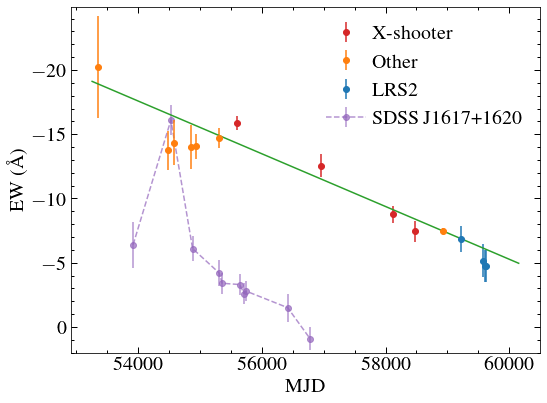

In [37]:
obsdates = [59563, 59594, 59625, 59653]


plt.figure(figsize=(8, 6))
plt.errorbar(datesx, np.sum(eqsx, axis=0), yerr= np.sum(ex**2, axis=0)**0.5, marker='o', ls='none', c= 'C3', label='X-shooter')
plt.errorbar(dates, np.sum(eqs, axis=0), yerr=np.sum(eqse**2, axis=0)**0.5, marker='o', ls='none', c= 'C1', label='Other')
#add lrs2
plt.errorbar(lrs2_mjd, np.sum(lrs2_ew), yerr=np.sum(lrs2_ewe**2)**0.5, marker='o', ls='none', c= 'C0', label='LRS2')
plt.errorbar(lrs2_mjd2, np.sum(lrs2_ew2), yerr=np.sum(lrs2_ewe2**2)**0.5, marker='o', ls='none', c= 'C0')
plt.errorbar(lrs2_mjd3, np.sum(lrs2_ew3), yerr=np.sum(lrs2_ewe3**2)**0.5, marker='o', ls='none', c= 'C0')
plt.errorbar(lrs2_mjd4, np.sum(lrs2_ew4), yerr=np.sum(lrs2_ewe4**2)**0.5, marker='o', ls='none', c= 'C0')

# plt.errorbar(dates, np.sum(eqs, axis=0), yerr=np.sum(eqse**2, axis=0)**0.5, marker='o', ls='none', c= 'C1', label='Other')


tplot = np.linspace(min(adates)-100, max(obsdates)+500, 100)
plt.plot(tplot, p_fit(tplot), c='C2')

# prediction = p_fit(np.mean(obsdates))
# plt.scatter(np.mean(obsdates), prediction, marker='x', label = 'Winter 2021 predicted EW = {0:.0f} \AA'.format(prediction), s=300)
# [plt.axvline(obs, ls='--', alpha=0.5, c='C2') for obs in obsdates]
# print(p_fit(obsdates))

plt.errorbar(t1617, ew1617,yerr= ew_e1617, marker='o', ls='--', c='C4', label = 'SDSS\,J1617+1620', alpha =0.7, zorder=-10)

plt.ylim(2, -24.9)
plt.legend()
plt.xlabel('MJD')
plt.ylabel('EW (\AA)')
plt.tight_layout()
plt.savefig('plots/sdssJ0845+2257_ews_202202.pdf')

20220324 consitently calculated lrs2 ews from het_results notebook

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
            slope              intercept     
    --------------------- -------------------
    0.0019924950461800294 -125.00413972327314
[1.52207073e-04 8.87113683e+00]
0.7277588156172557 Angstrom / yr
0.055593633591396345 Angstrom / yr


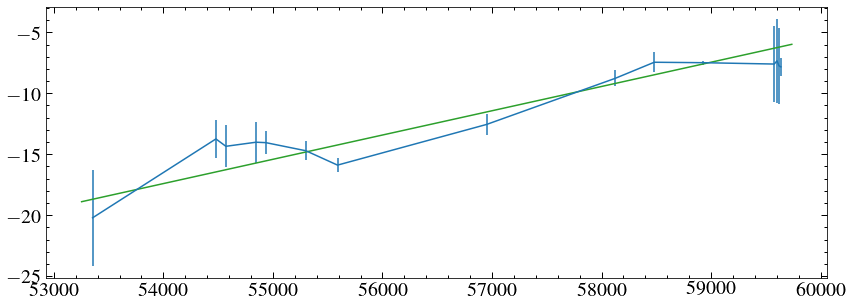

In [58]:
lrs2_mjds, lrs2_ews, lrs2_ewes = np.loadtxt('het_results/WDJ0845+2257_lrs2_ews.dat', unpack=True)

sdss0845_dates = np.concatenate((dates, datesx, [lrs2_mjd, lrs2_mjd2, lrs2_mjd3, lrs2_mjd4]))
args = np.argsort(sdss0845_dates)
sdss0845_dates = sdss0845_dates[args] 
sdss0845_ews = np.concatenate((np.sum(eqs, axis=0), np.sum(eqsx, axis=0), [np.sum(lrs2_ew), np.sum(lrs2_ew2), np.sum(lrs2_ew3), np.sum(lrs2_ew4)]))[args]
sdss0845_ewes = np.concatenate((np.sum(eqse**2, axis=0)**0.5, np.sum(ex**2, axis=0)**0.5, [np.sum(lrs2_ewe**2)**0.5, np.sum(lrs2_ewe2**2)**0.5, np.sum(lrs2_ewe3**2)**0.5, np.sum(lrs2_ewe4**2)**0.5]))[args]

sdss0845_dates = np.concatenate((dates, datesx, lrs2_mjds))
args = np.argsort(sdss0845_dates)
sdss0845_dates = sdss0845_dates[args] 
sdss0845_ews = np.concatenate((np.sum(eqs, axis=0), np.sum(eqsx, axis=0), lrs2_ews))[args]
sdss0845_ewes = np.concatenate((np.sum(eqse**2, axis=0)**0.5, np.sum(ex**2, axis=0)**0.5, lrs2_ewes))[args]



plt.errorbar(sdss0845_dates, sdss0845_ews, sdss0845_ewes)

fitter = fitting.LevMarLSQFitter()
p_init = models.Linear1D()
# p_fit = fitter(p_init, adates[6:], aew[6:], weights = 1/aewe[6:])
p_fit = fitter(p_init, sdss0845_dates, sdss0845_ews, weights = 1/sdss0845_ewes)
tplot = np.linspace(min(sdss0845_dates)-100, max(sdss0845_dates)+100, 100)
plt.plot(tplot, p_fit(tplot), c='C2')
print(p_fit)
#print(fitter.fit_info)
fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
print(fit_e)

slope = (p_fit.slope*u.AA/u.d).to(u.AA/u.yr)
print(slope)
print((fit_e[0]/p_fit.slope)*slope)

In [59]:
#sdssj1617+160 redo
sdss1617_path = '/media/david/2tb_ext_hd/hddata/het_gas/sdss1617/spectra/triplet_spectra/'
specs = glob.glob('{}/*.dat'.format(sdss1617_path))
# for spec in specs:
    # print(spec)
#     w, f, e = np.loadtxt(spec, unpack=True, usecols=[0, 1, 2])
#     mask = (w > 8450) & (w < 8700) 
#     plt.plot(w[mask], f[mask])
#     plt.show()
sdss1617_specs = ['/media/david/2tb_ext_hd/hddata/het_gas/sdss1617/spectra/triplet_spectra/SDSSJ161717.04+162022.3_53918-2198-0541.dat',
                 '/media/david/2tb_ext_hd/hddata/het_gas/sdss1617/spectra/triplet_spectra/SDSSJ161717.04+162022.3_54557-2177-0107.dat',
                 '/media/david/2tb_ext_hd/hddata/het_gas/sdss1617/spectra/triplet_spectra/sdss1617_200902_wht_red.dat',
                 '/media/david/2tb_ext_hd/hddata/het_gas/sdss1617/spectra/triplet_spectra/sdss1617_201004_wht_red.dat',
                 '/media/david/2tb_ext_hd/hddata/het_gas/sdss1617/spectra/triplet_spectra/sdss1617_201006_gn_8260-8960.dat',
                 '/media/david/2tb_ext_hd/hddata/het_gas/sdss1617/spectra/triplet_spectra/SDSSJ1617+1620_VIS_xshooter_20110321.dat',
                 '/media/david/2tb_ext_hd/hddata/het_gas/sdss1617/spectra/triplet_spectra/SDSSJ1617+1620_VIS_xshooter_20110531.dat',
                 '/media/david/2tb_ext_hd/hddata/het_gas/sdss1617/spectra/triplet_spectra/SDSSJ1617+1620_VIS_xshooter_20110627.dat',
                 '/media/david/2tb_ext_hd/hddata/het_gas/sdss1617/spectra/triplet_spectra/SDSSJ1617+1620_RedU_uves_20130505.dat',
                 '/media/david/2tb_ext_hd/hddata/het_gas/sdss1617/spectra/triplet_spectra/SDSSJ1617+1620__FORS_20140430.dat']

/media/david/2tb_ext_hd/hddata/het_gas/sdss1617/spectra/triplet_spectra/SDSSJ161717.04+162022.3_53918-2198-0541.dat


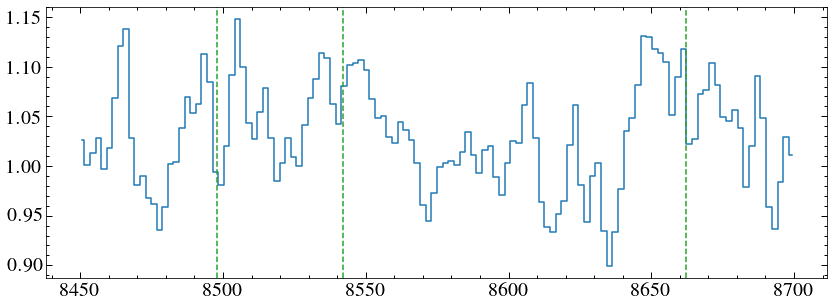

/media/david/2tb_ext_hd/hddata/het_gas/sdss1617/spectra/triplet_spectra/SDSSJ161717.04+162022.3_54557-2177-0107.dat


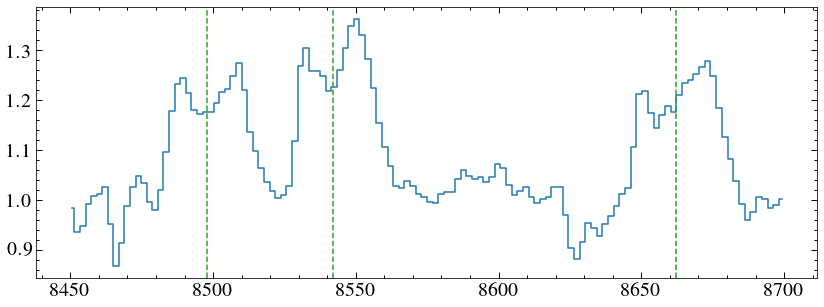

/media/david/2tb_ext_hd/hddata/het_gas/sdss1617/spectra/triplet_spectra/sdss1617_200902_wht_red.dat


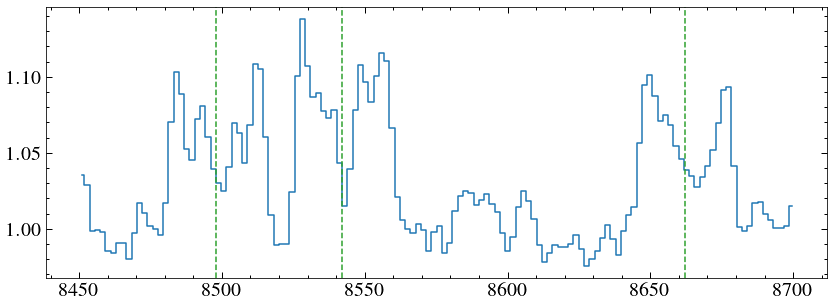

/media/david/2tb_ext_hd/hddata/het_gas/sdss1617/spectra/triplet_spectra/sdss1617_201004_wht_red.dat


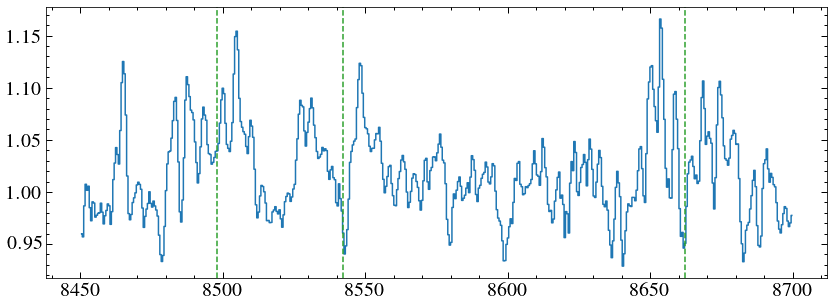

/media/david/2tb_ext_hd/hddata/het_gas/sdss1617/spectra/triplet_spectra/sdss1617_201006_gn_8260-8960.dat


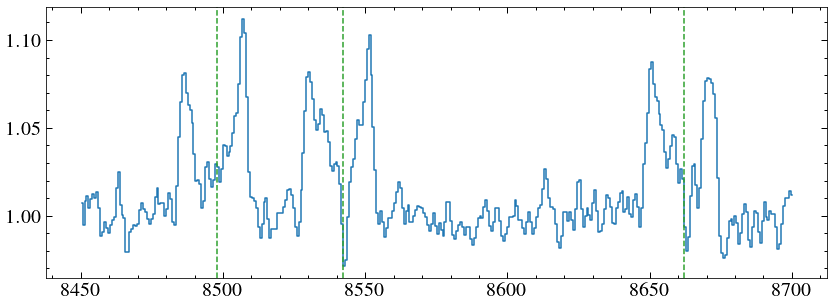

/media/david/2tb_ext_hd/hddata/het_gas/sdss1617/spectra/triplet_spectra/SDSSJ1617+1620_VIS_xshooter_20110321.dat


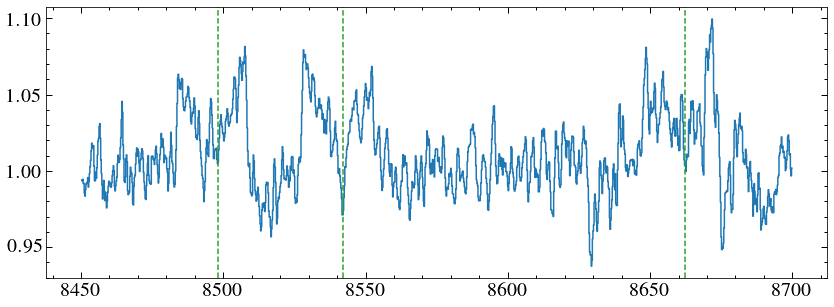

/media/david/2tb_ext_hd/hddata/het_gas/sdss1617/spectra/triplet_spectra/SDSSJ1617+1620_VIS_xshooter_20110531.dat


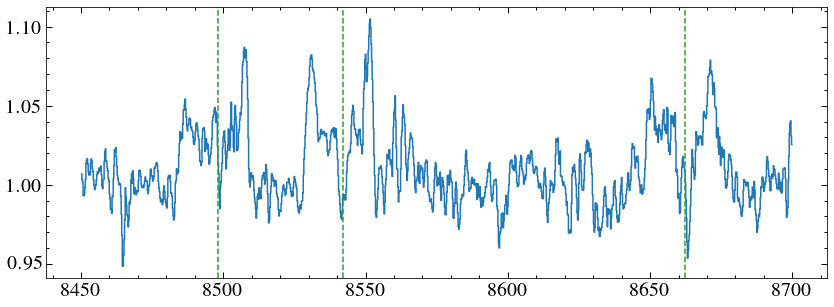

/media/david/2tb_ext_hd/hddata/het_gas/sdss1617/spectra/triplet_spectra/SDSSJ1617+1620_VIS_xshooter_20110627.dat


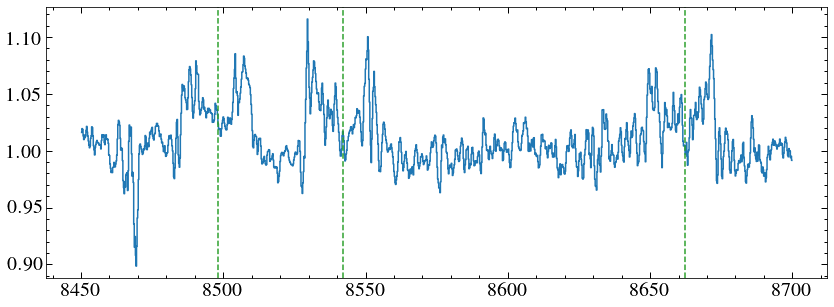

/media/david/2tb_ext_hd/hddata/het_gas/sdss1617/spectra/triplet_spectra/SDSSJ1617+1620_RedU_uves_20130505.dat


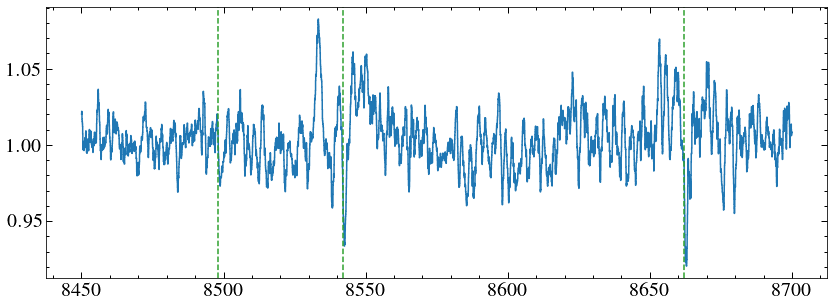

/media/david/2tb_ext_hd/hddata/het_gas/sdss1617/spectra/triplet_spectra/SDSSJ1617+1620__FORS_20140430.dat


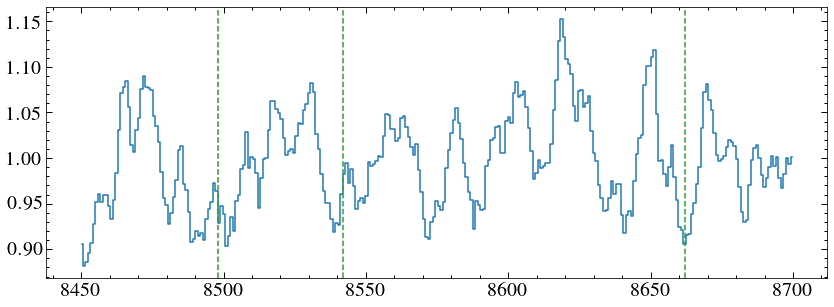

In [40]:
# w, f, e = np.loadtxt(sdss1617_specs[1], unpack=True, usecols=[0, 1, 2])
# mask = (w > 8450) & (w < 8700) 
# plt.plot(w[mask], f[mask])



trips2 = [[8480,8523], [8526,8565], [8645, 8685]]

# for trip in trips2:
    # [plt.axvline(line, c='C1') for line in trip] 

# plt.show()    

sdss1617_ews = []
sdss1617_ewes = []

lines = [8498.02,8542.09,8662.14]   

bins = [2, 2, 2, 4, 2,5,5,5,20, 5]
for i, spec in enumerate(sdss1617_specs):
    print(spec)
    w, f, e = np.loadtxt(spec, unpack=True, usecols=[0, 1, 2])
    mask1 = (w > 8400) & (w < 8480) | (w > 8523) & (w < 8526) | (w > 8565)  & (w< 8645) | (w > 8685) & (w < 8750)
    mask2 = (w> 8450) & (w < 8700) 
    wn, fn, en =  make_plot_spec(w, f,e , mask1, mask2, smooth=bins[i])
    plt.step(wn, fn, where='mid')
    [plt.axvline(line, ls='--', c='C2') for line in lines]

    plt.show()
    
    w0, w1 = wavelength_edges(wn)

    ews = []
    ewes = []
    for j , trip in enumerate(trips2):
        mask = (wn > trip[0]) & (wn < trip[1])
        eqw = np.sum((1-fn[mask])*(w1[mask]-w0[mask]))
        #eqw_e = (np.sum(e[mask]**2 * (w1[mask]-w0[mask])**2))**0.5
        eqw_e=((1.+(1./np.mean(fn[mask])))**(0.5)) * (((wn[mask][-1]-wn[mask][0])-eqw)/(np.mean(fn[mask])/np.mean(en[mask])))
        ews.append(eqw)
        ewes.append(eqw_e)
    ews, ewes = np.array(ews), np.array(ewes)
    sdss1617_ews.append(np.sum(ews))
    sdss1617_ewes.append(np.sum(ewes**2)**0.5)
    
sdss1617_ews, sdss1617_ewes = np.array(sdss1617_ews), np.array(sdss1617_ewes)
# plt.xlim(8451, 8699)

# for trip in trips:
#     [plt.axvline(line) for line in trip]
    


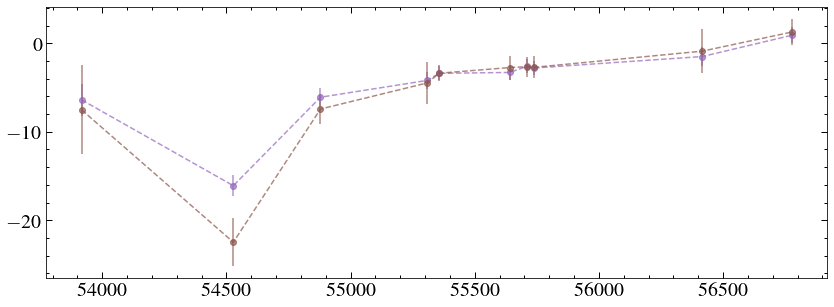

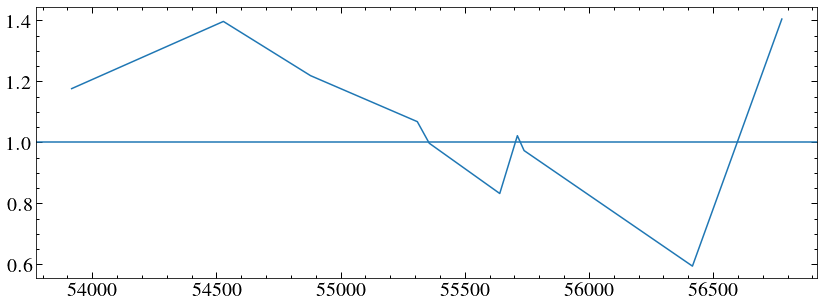

In [41]:
sdss1617_dates = np.array(t1617)
plt.errorbar(t1617, ew1617,yerr= ew_e1617, marker='o', ls='--', c='C4', label = 'SDSS\,J1617+1620', alpha =0.7, zorder=-10)
plt.errorbar(t1617, sdss1617_ews,yerr= sdss1617_ewes, marker='o', ls='--', c='C5', label = 'SDSS\,J1617+1620', alpha =0.7, zorder=-10)
plt.show()

plt.plot(t1617, sdss1617_ews/ew1617)
plt.axhline(1)

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
            slope              intercept     
    --------------------- -------------------
    0.0038535171894510225 -217.36394251164347
[5.03780977e-04 2.80438339e+01]
1.407497153446986 Angstrom / yr
0.18400600168808331 Angstrom / yr


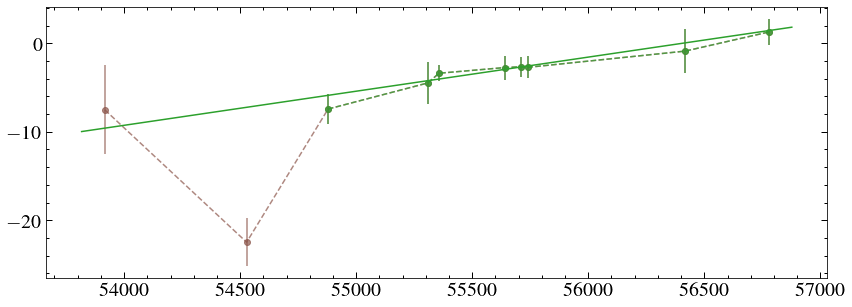

In [42]:
p_init = models.Linear1D()
# p_fit = fitter(p_init, adates[6:], aew[6:], weights = 1/aewe[6:])
p1617_fit = fitter(p_init, sdss1617_dates[2:], sdss1617_ews[2:], weights = 1/sdss1617_ewes[2:])
tplot = np.linspace(min(sdss1617_dates)-100, max(sdss1617_dates)+100, 100)

plt.errorbar(t1617, sdss1617_ews,yerr= sdss1617_ewes, marker='o', ls='--', c='C5', label = 'SDSS\,J1617+1620', alpha =0.7, zorder=-10)
plt.errorbar(t1617[2:], sdss1617_ews[2:],yerr= sdss1617_ewes[2:], marker='o', ls='--', c='C2', label = 'SDSS\,J1617+1620', alpha =0.7, zorder=-10)

plt.plot(tplot, p1617_fit(tplot), c='C2')
print(p1617_fit)
#print(fitter.fit_info)
fit1617_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
print(fit1617_e)

slope1617 = (p1617_fit.slope*u.AA/u.d).to(u.AA/u.yr)
print(slope1617)
print((fit1617_e[0]/p1617_fit.slope)*slope1617)

In [43]:
sdss1617_dates

array([53917., 54528., 54879., 55309., 55357., 55641., 55712., 55739.,
       56417., 56777.])

0.87471624815958 Angstrom / yr
0.07202063101288353 Angstrom / yr


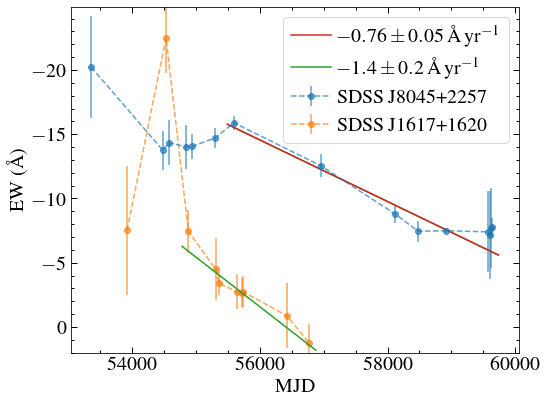

In [57]:
# sdss0845_dates = np.concatenate((dates, datesx, [lrs2_mjd, lrs2_mjd2, lrs2_mjd3, lrs2_mjd4]))
# args = np.argsort(sdss0845_dates)
# sdss0845_dates = sdss0845_dates[args] 
# sdss0845_ews = np.concatenate((np.sum(eqs, axis=0), np.sum(eqsx, axis=0), [np.sum(lrs2_ew), np.sum(lrs2_ew2), np.sum(lrs2_ew3), np.sum(lrs2_ew4)]))[args]
# sdss0845_ewes = np.concatenate((np.sum(eqse**2, axis=0)**0.5, np.sum(ex**2, axis=0)**0.5, [np.sum(lrs2_ewe**2)**0.5, np.sum(lrs2_ewe2**2)**0.5, np.sum(lrs2_ewe3**2)**0.5, np.sum(lrs2_ewe4**2)**0.5]))[args]

plt.figure(figsize=(8, 6))

plt.errorbar(sdss0845_dates, sdss0845_ews, sdss0845_ewes, c='C0',label = 'SDSS\,J8045+2257', marker='o', ls='--', alpha=0.7)

fitter = fitting.LevMarLSQFitter()
p_init = models.Linear1D()
# p_fit = fitter(p_init, adates[6:], aew[6:], weights = 1/aewe[6:])
p_fit = fitter(p_init, sdss0845_dates[6:], sdss0845_ews[6:], weights = 1/sdss0845_ewes[6:])
# p_fit = fitter(p_init, sdss0845_dates, sdss0845_ews, weights = 1/sdss0845_ewes)
tplot = np.linspace(min(sdss0845_dates[6:])-100, max(sdss0845_dates[6:])+100, 100)
plt.plot(tplot, p_fit(tplot), c='C2')
# print(p_fit)
#print(fitter.fit_info)
fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
# print(fit_e)

slope = (p_fit.slope*u.AA/u.d).to(u.AA/u.yr)
print(slope)
print((fit_e[0]/p_fit.slope)*slope)


plt.ylim(2, -24.9)

plt.errorbar(t1617, sdss1617_ews,yerr= sdss1617_ewes, marker='o', ls='--', c='C1', label = 'SDSS\,J1617+1620', alpha =0.7, zorder=-10)

plt.plot(tplot, p_fit(tplot), c='C3', label = r'$-0.76\pm 0.05$\,\AA\,yr$^{-1}$')


tplot = np.linspace(min(sdss1617_dates[2:])-100, max(sdss1617_dates[2:])+100, 100)

plt.plot(tplot, p1617_fit(tplot), c='C2', label = r'$-1.4\pm 0.2$\,\AA\,yr$^{-1}$')



plt.legend(frameon=True)
plt.xlabel('MJD')
plt.ylabel('EW (\AA)')
plt.tight_layout()


In [45]:
slope/slope1617

<Quantity 0.54158885>

In [46]:
13520/19780

0.6835187057633973